In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import calendar
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score,mean_squared_error,mean_absolute_error,r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
!pip install xgboost
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error

In [3]:
# Loading the data

sales_data = pd.read_csv('sales.csv')
items_data= pd.read_csv('items.csv')
restaurants_data= pd.read_csv('resturants.csv')

In [4]:
sales_data.head()

date  item_id  price  item_count
0  2019-01-01        3  29.22         2.0
1  2019-01-01        4  26.42        22.0
2  2019-01-01       12   4.87         7.0
3  2019-01-01       13   4.18        12.0
4  2019-01-01       16   3.21       136.0

In [5]:
items_data.head()

id  store_id                               name  kcal   cost
0   1         4                     Chocolate Cake   554   6.71
1   2         4  Breaded Fish with Vegetables Meal   772  15.09
2   3         1                  Sweet Fruity Cake   931  29.22
3   4         1    Amazing Steak Dinner with Rolls   763  26.42
4   5         5                          Milk Cake   583   6.07

In [6]:
restaurants_data.head()

id            name
0   1     Bob's Diner
1   2  Beachfront Bar
2   3     Sweet Shack
3   4        Fou Cher
4   5     Corner Cafe

In [7]:
sales_data.info()
sales_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109600 entries, 0 to 109599
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        109600 non-null  object 
 1   item_id     109600 non-null  int64  
 2   price       109600 non-null  float64
 3   item_count  109600 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.3+ MB


(109600, 4)

In [8]:
items_data.info()
items_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        100 non-null    int64  
 1   store_id  100 non-null    int64  
 2   name      100 non-null    object 
 3   kcal      100 non-null    int64  
 4   cost      100 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 4.0+ KB


(100, 5)

In [9]:

restaurants_data.info()
restaurants_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6 non-null      int64 
 1   name    6 non-null      object
dtypes: int64(1), object(1)
memory usage: 224.0+ bytes


(6, 2)

In [10]:
sales_data.describe()

item_id          price     item_count
count  109600.000000  109600.000000  109600.000000
mean       50.500000      11.763700       6.339297
std        28.866202       8.946225      30.003728
min         1.000000       1.390000       0.000000
25%        25.750000       5.280000       0.000000
50%        50.500000       7.625000       0.000000
75%        75.250000      18.790000       0.000000
max       100.000000      53.980000     570.000000

In [11]:
restaurants_data.describe()

id
count  6.000000
mean   3.500000
std    1.870829
min    1.000000
25%    2.250000
50%    3.500000
75%    4.750000
max    6.000000

In [12]:
items_data.describe()

id    store_id         kcal        cost
count  100.000000  100.000000   100.000000  100.000000
mean    50.500000    3.520000   536.730000   11.763700
std     29.011492    1.708446   202.212852    8.991254
min      1.000000    1.000000    78.000000    1.390000
25%     25.750000    2.000000   406.250000    5.280000
50%     50.500000    4.000000   572.500000    7.625000
75%     75.250000    5.000000   638.250000   18.790000
max    100.000000    6.000000  1023.000000   53.980000

In [13]:
# Function to detect the outliers

def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers



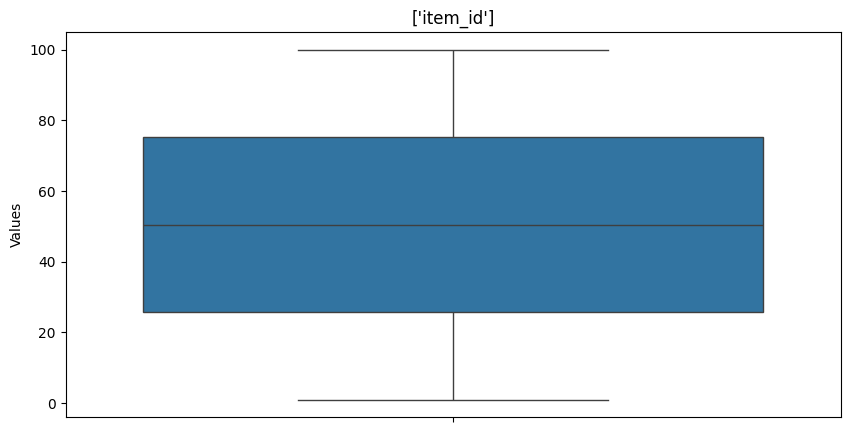

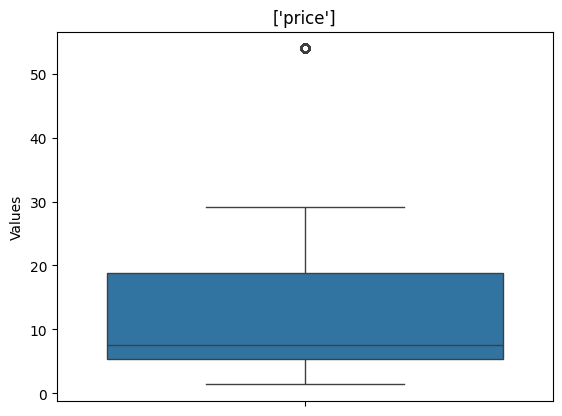

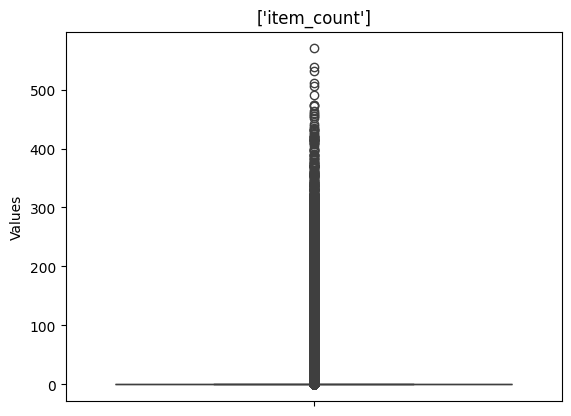

In [14]:
# Outlier detection using boxplot

plt.figure(figsize=(10, 5))
for i in sales_data.columns[1:4]:
            sns.boxplot(sales_data[i])
            plt.title([i])
            plt.xticks(rotation=90)
            plt.ylabel('Values')
            plt.show()

In [15]:
# Merging the datasets
# First, merge items with sales on item_id
sales_items = pd.merge(sales_data, items_data, left_on='item_id', right_on='id',how='left')

# Now, merge with restaurants on store_id
final_data = pd.merge(sales_items, restaurants_data, left_on='store_id', right_on='id', suffixes=('_item', '_store'))
#final_data.head()
final_data.drop(columns=['id_item', 'id_store','cost'], inplace=True)

In [16]:
final_data.head()

date  item_id  price  item_count  store_id  \
0  2019-01-01        3  29.22         2.0         1   
1  2019-01-01        4  26.42        22.0         1   
2  2019-01-01       12   4.87         7.0         1   
3  2019-01-01       13   4.18        12.0         1   
4  2019-01-01       16   3.21       136.0         1   

                         name_item  kcal   name_store  
0                Sweet Fruity Cake   931  Bob's Diner  
1  Amazing Steak Dinner with Rolls   763  Bob's Diner  
2             Fantastic Sweet Cola   478  Bob's Diner  
3          Sweet Frozen Soft Drink   490  Bob's Diner  
4             Frozen Milky Smoothy   284  Bob's Diner

In [17]:
final_data.shape

(109600, 8)

## Exploratory data analysis

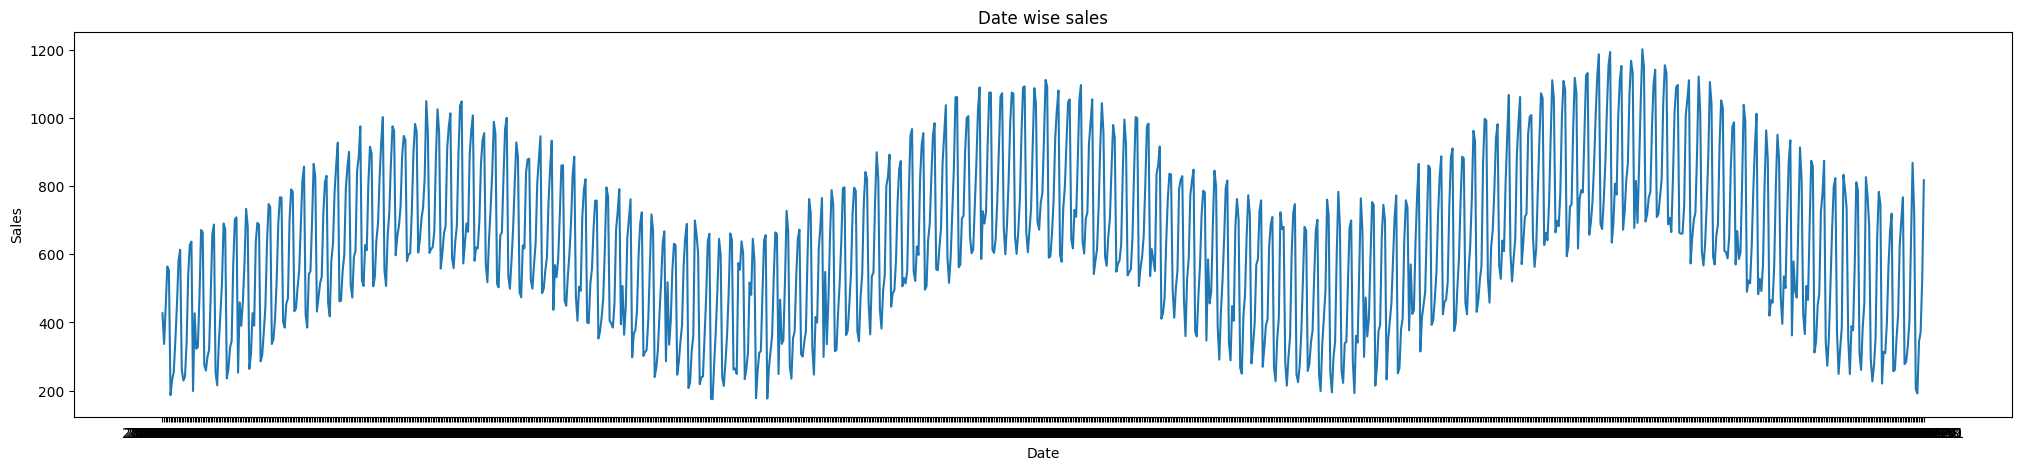

In [18]:
# Date wise sales

group_date=final_data.groupby(['date'])[['item_count']].sum()
plt.figure(figsize=(25,5))
plt.plot(group_date)
plt.title('Date wise sales')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.show()

Text(0.5, 1.0, 'Sales fluctuation across different days of the week')

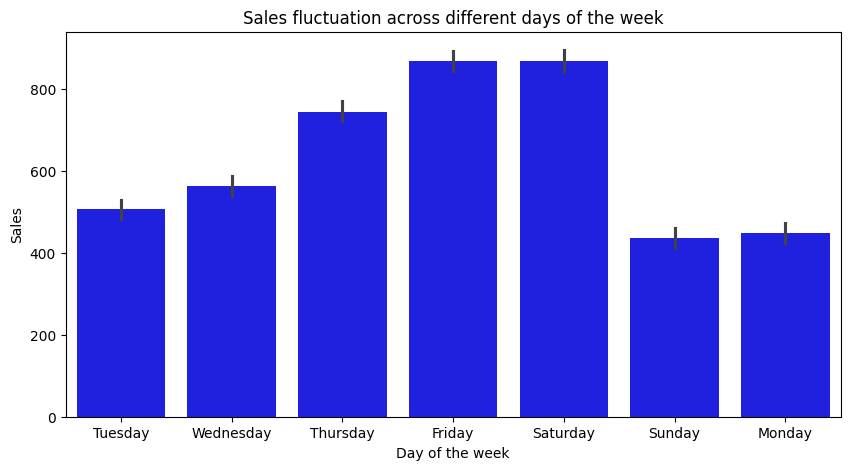

In [19]:
# Sales fluctuation across different days of the week

final_data['date'] = pd.to_datetime(final_data['date'])
final_data = final_data.set_index('date')

group_day=final_data.resample('D').sum()
plt.figure(figsize=(10,5))
sns.barplot(x=group_day.index.day_name(),y=group_day['item_count'],color='blue')
plt.xlabel('Day of the week')
plt.ylabel('Sales')
plt.title('Sales fluctuation across different days of the week')

Observation - Sales is highest on weekends(Friday and Saturday)

Text(0.5, 1.0, 'Sales fluctuation across different months of the year')

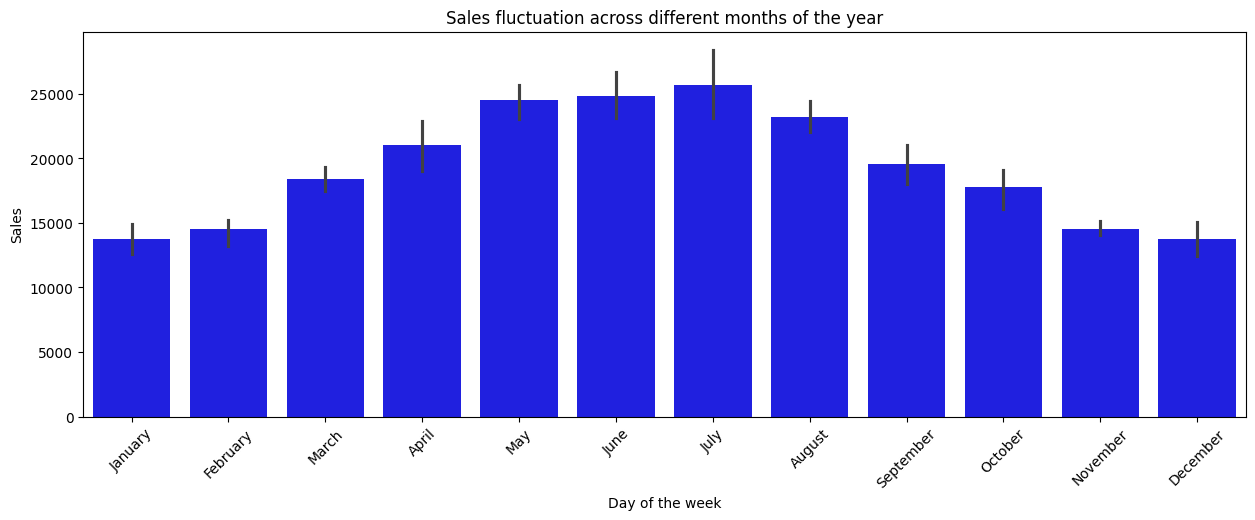

In [20]:
# Sales fluctuation across different months of the year
group_month=final_data.resample('M').sum()
plt.figure(figsize=(15,5))
sns.barplot(x=group_month.index.month_name(),y=group_month['item_count'],color='blue')
plt.xlabel('Day of the week')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.title('Sales fluctuation across different months of the year')

Observation - Highest sales has been observed in July followed by May and June


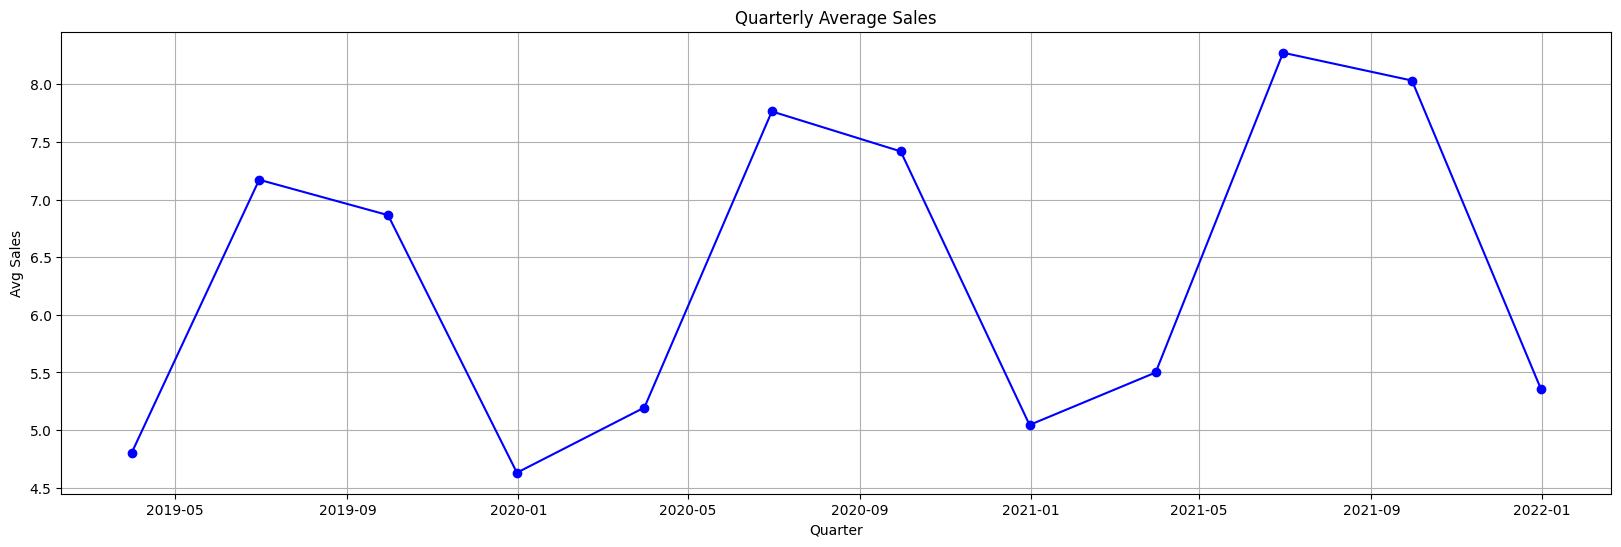

In [21]:
# Sales distribution across different quarters averaged over the years

Quarterly_sales = final_data['item_count'].resample('Q').mean()

plt.figure(figsize=(20,6))
plt.plot(Quarterly_sales.index,Quarterly_sales.values,marker='o',linestyle='-',color='b')
plt.title('Quarterly Average Sales')
plt.xlabel('Quarter')
plt.ylabel('Avg Sales')
plt.grid(True)
plt.show()

Observation - Sales is less in the first quarter of the year and picks up in the second and third quarter

Text(0.5, 1.0, 'Performances of the different restaurants')

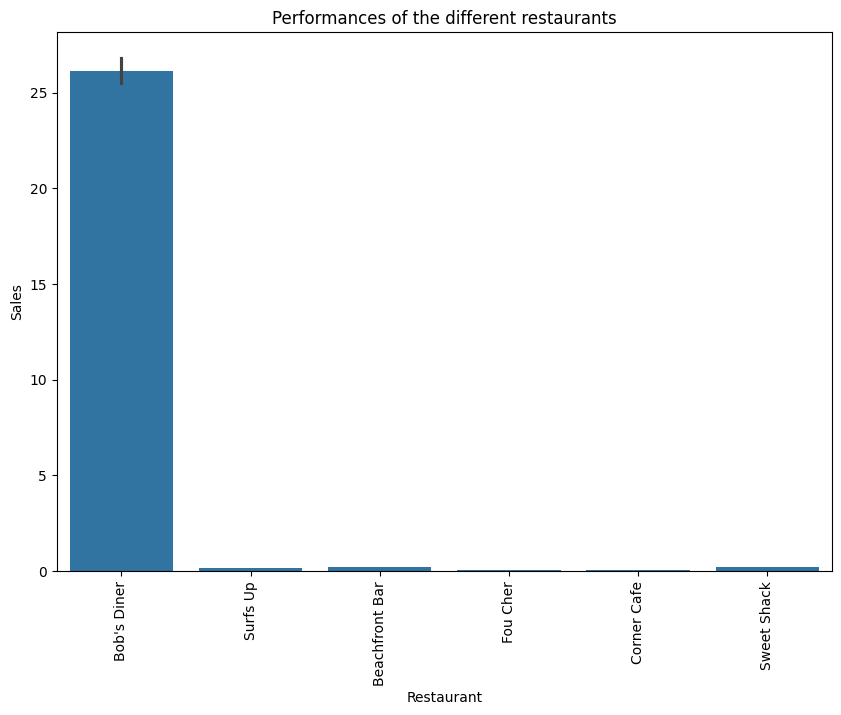

In [22]:
# Performances of the different restaurants

plt.figure(figsize=(10,7))
sns.barplot(x=final_data['name_store'],y=final_data['item_count'])
plt.xlabel('Restaurant')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.title('Performances of the different restaurants')

([<matplotlib.axis.XTick at 0x7b49ddc10a90>,
 [Text(1, 0, "Bob's Diner"),
  Text(2, 0, 'Beachfront Bar'),
  Text(3, 0, 'Sweet Shack'),
  Text(4, 0, 'Fou Cher'),
  Text(5, 0, 'Corner Cafe'),
  Text(6, 0, 'Surfs Up')])

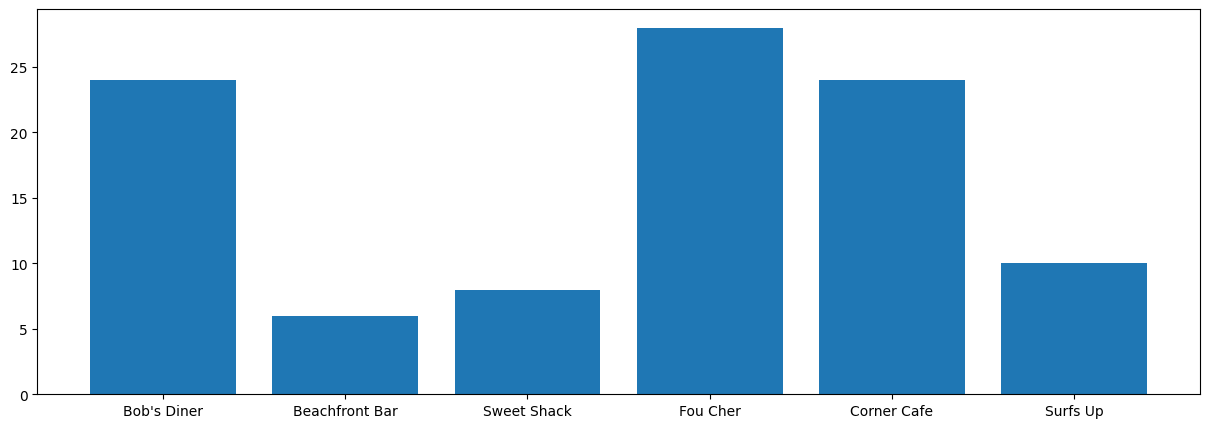

In [23]:
# Items served by different restaurants
items_served = items_data.groupby(['store_id']).agg({'id' : "nunique"}).squeeze()
plt.figure(figsize = (15,5))
plt.bar(items_served.index, items_served.values)
plt.xticks(range(1,7), restaurants_data.name)

In [24]:
final_data.head()

item_id  price  item_count  store_id  \
date                                               
2019-01-01        3  29.22         2.0         1   
2019-01-01        4  26.42        22.0         1   
2019-01-01       12   4.87         7.0         1   
2019-01-01       13   4.18        12.0         1   
2019-01-01       16   3.21       136.0         1   

                                  name_item  kcal   name_store  
date                                                            
2019-01-01                Sweet Fruity Cake   931  Bob's Diner  
2019-01-01  Amazing Steak Dinner with Rolls   763  Bob's Diner  
2019-01-01             Fantastic Sweet Cola   478  Bob's Diner  
2019-01-01          Sweet Frozen Soft Drink   490  Bob's Diner  
2019-01-01             Frozen Milky Smoothy   284  Bob's Diner

Observation - Bob's Diner has got the maximum sales

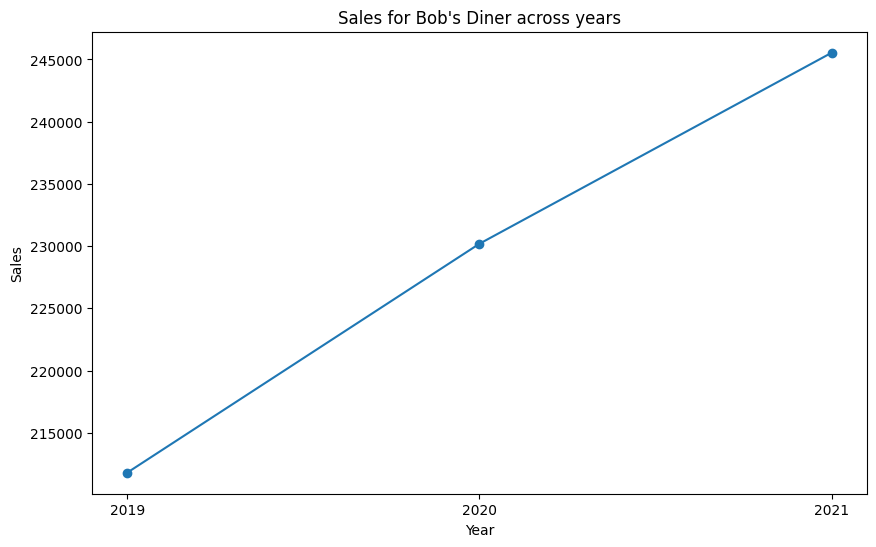

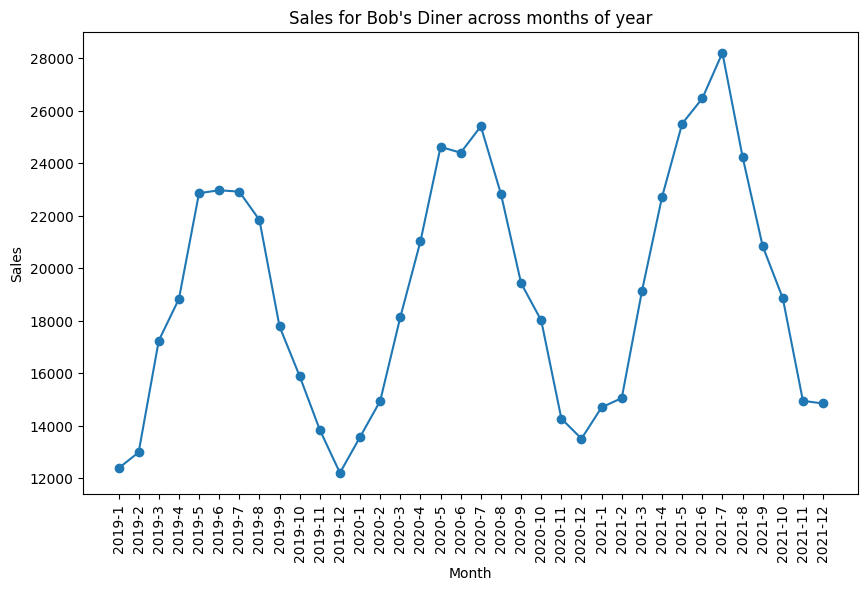

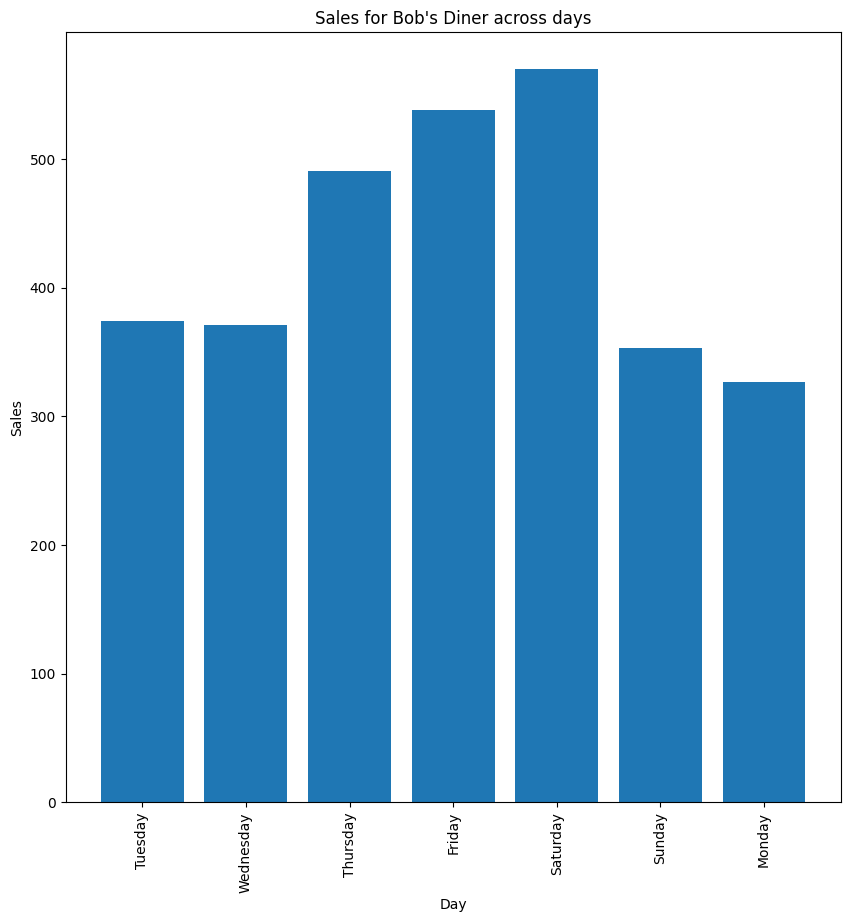

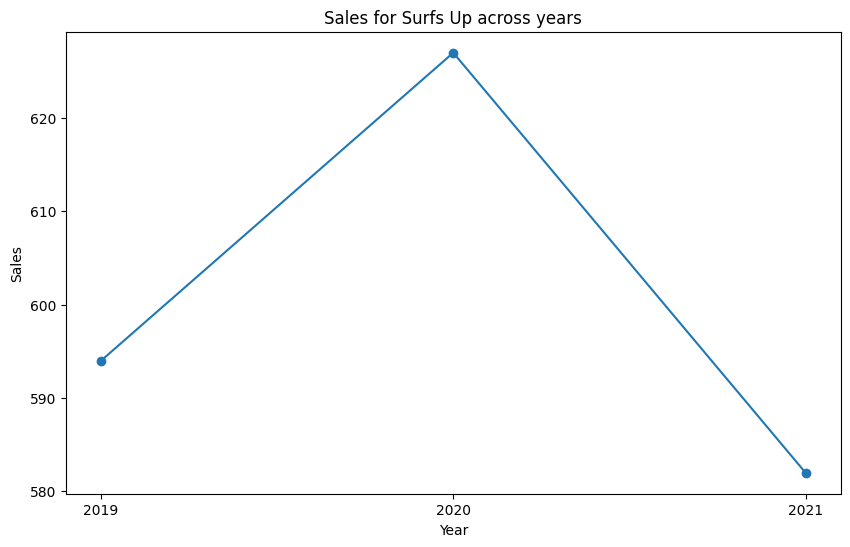

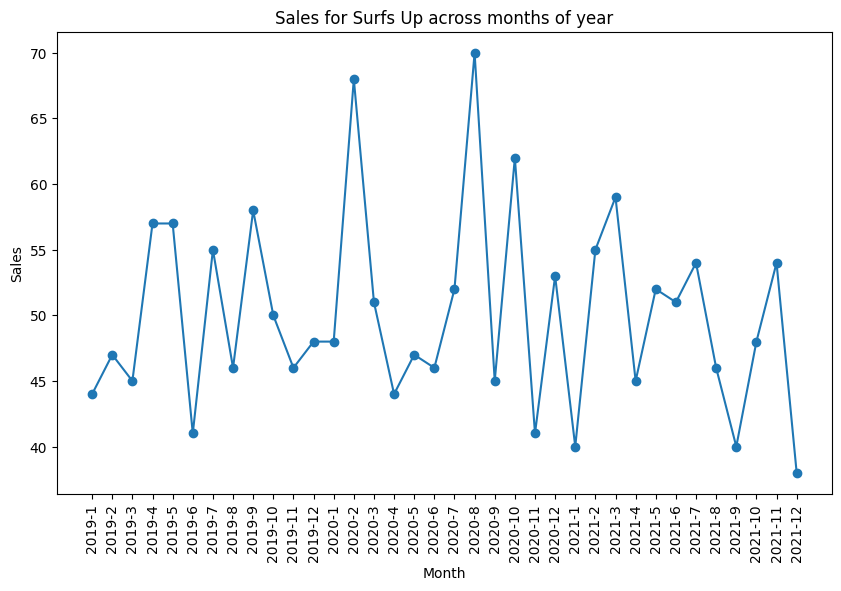

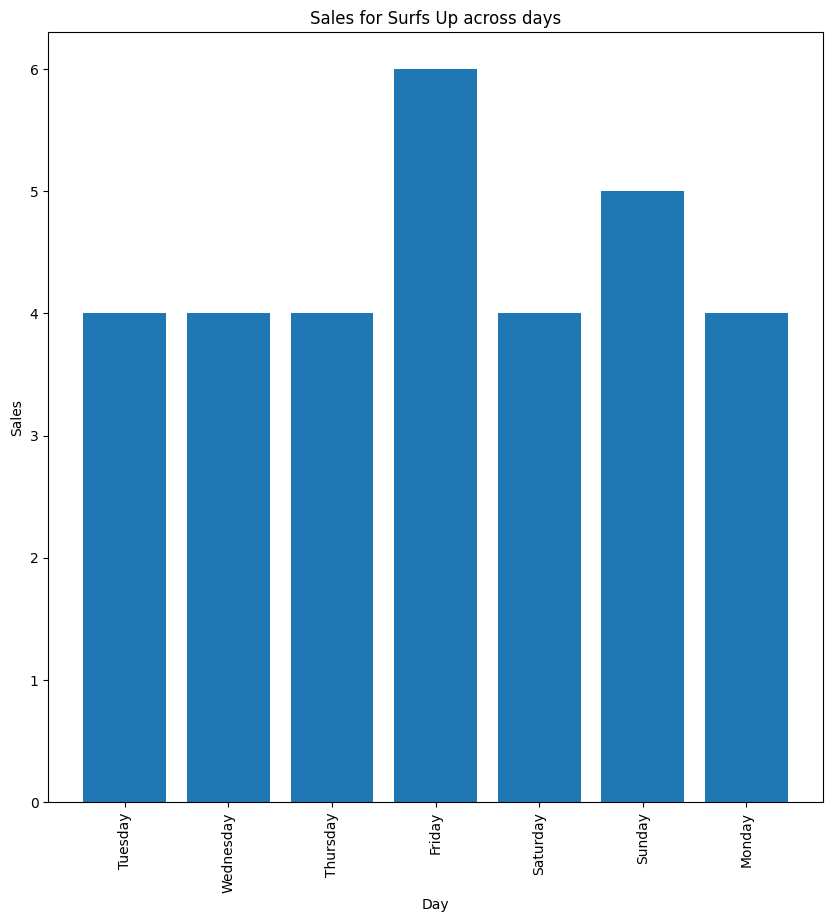

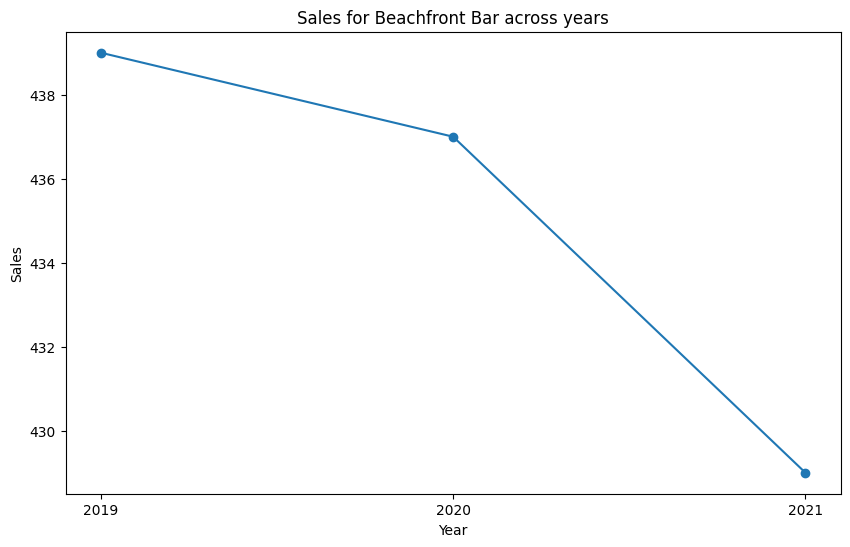

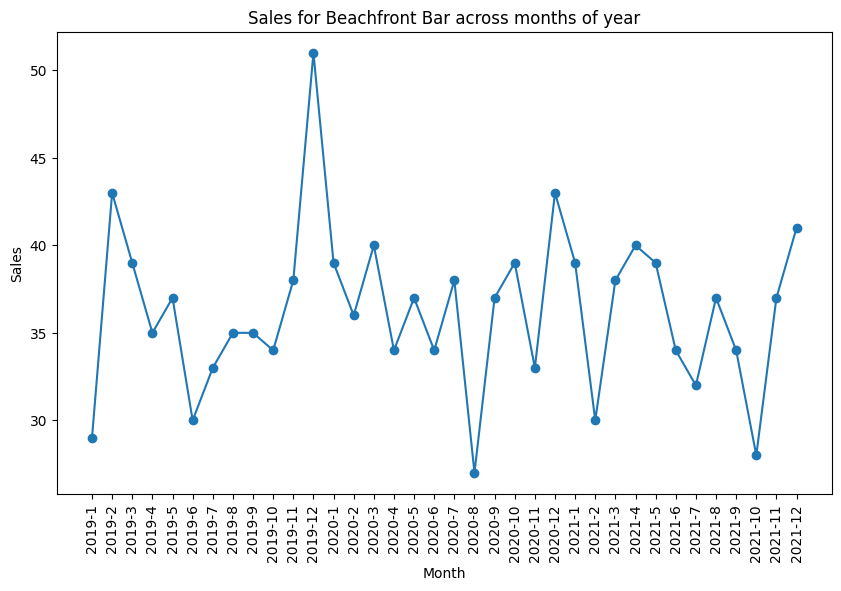

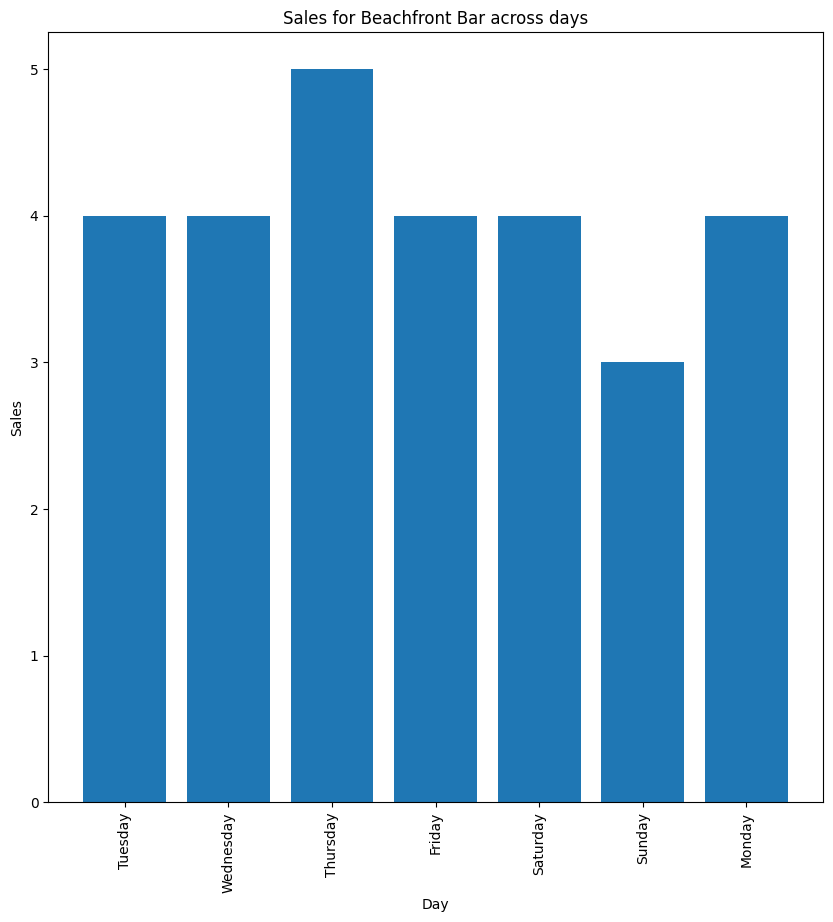

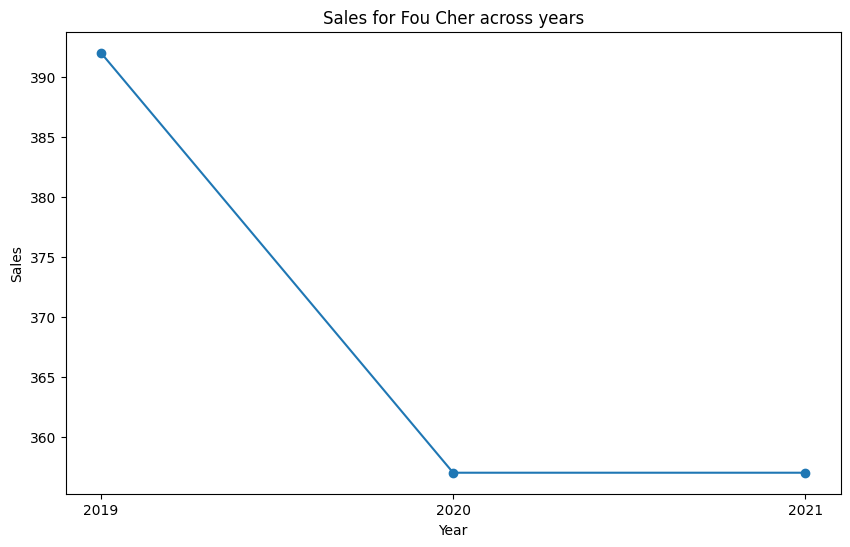

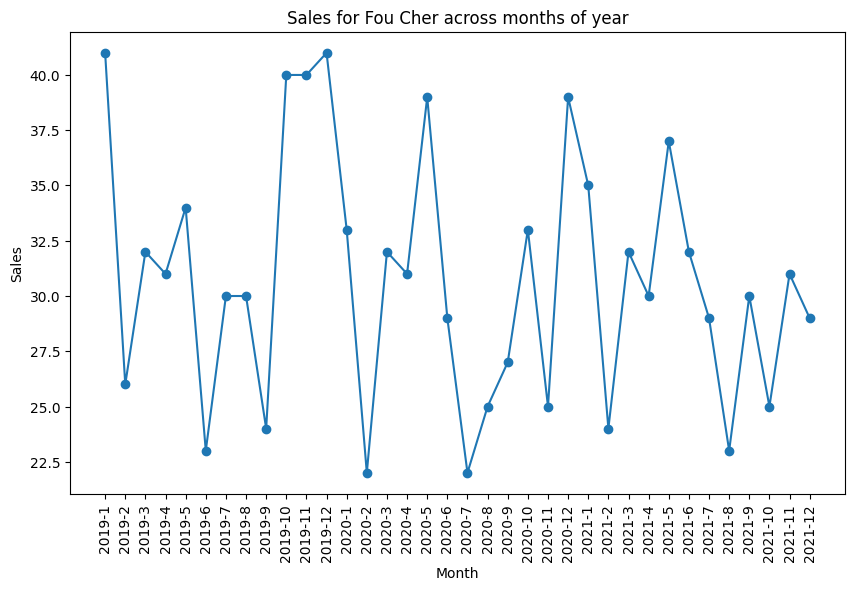

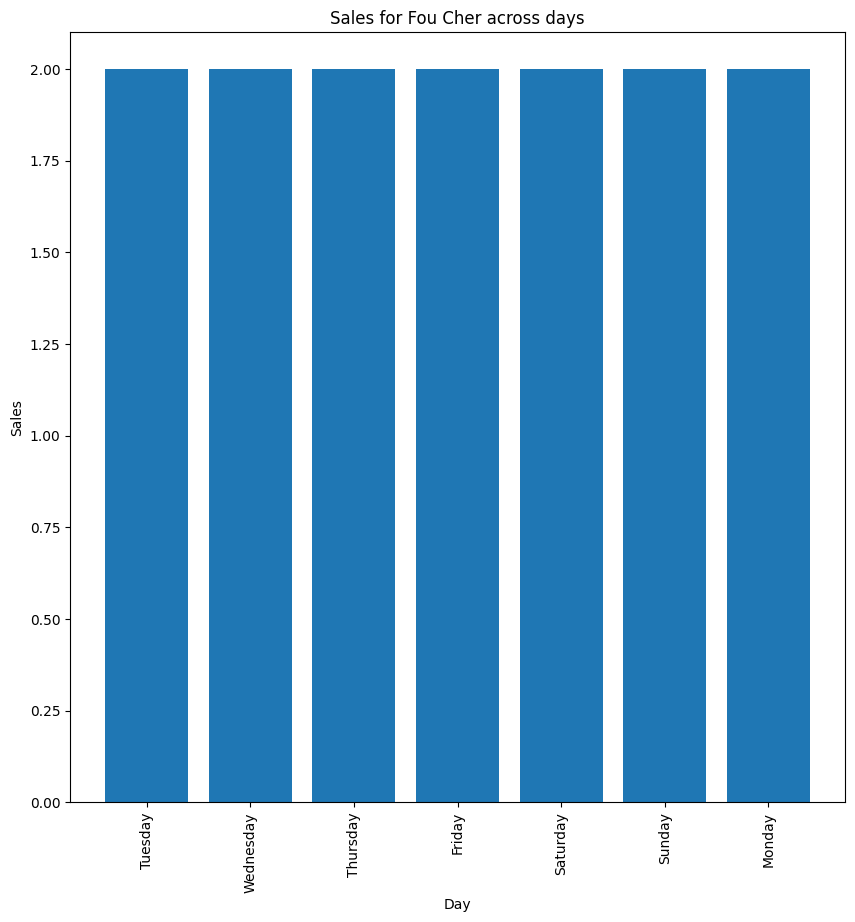

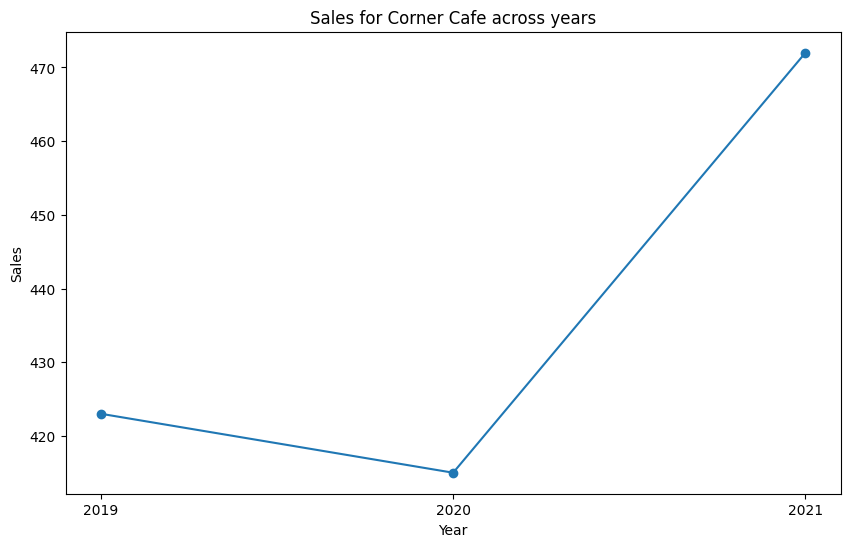

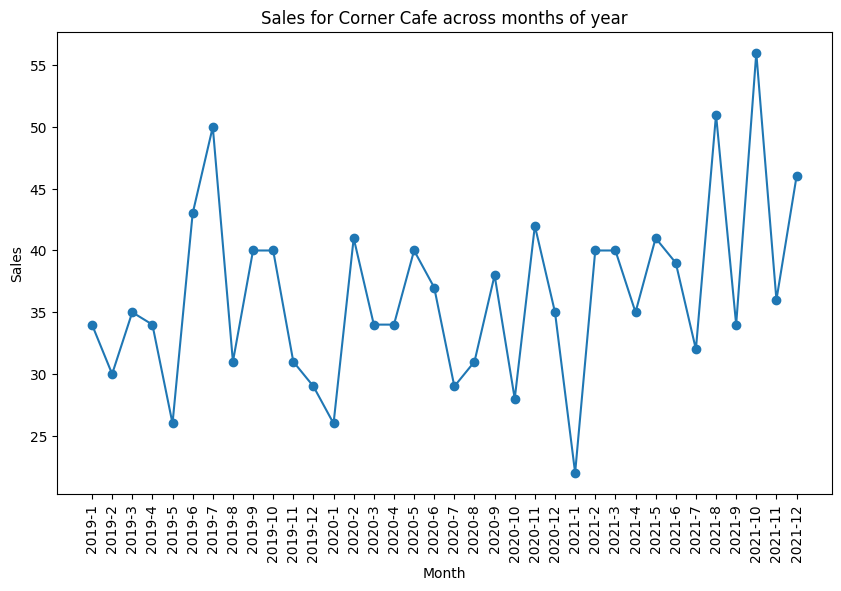

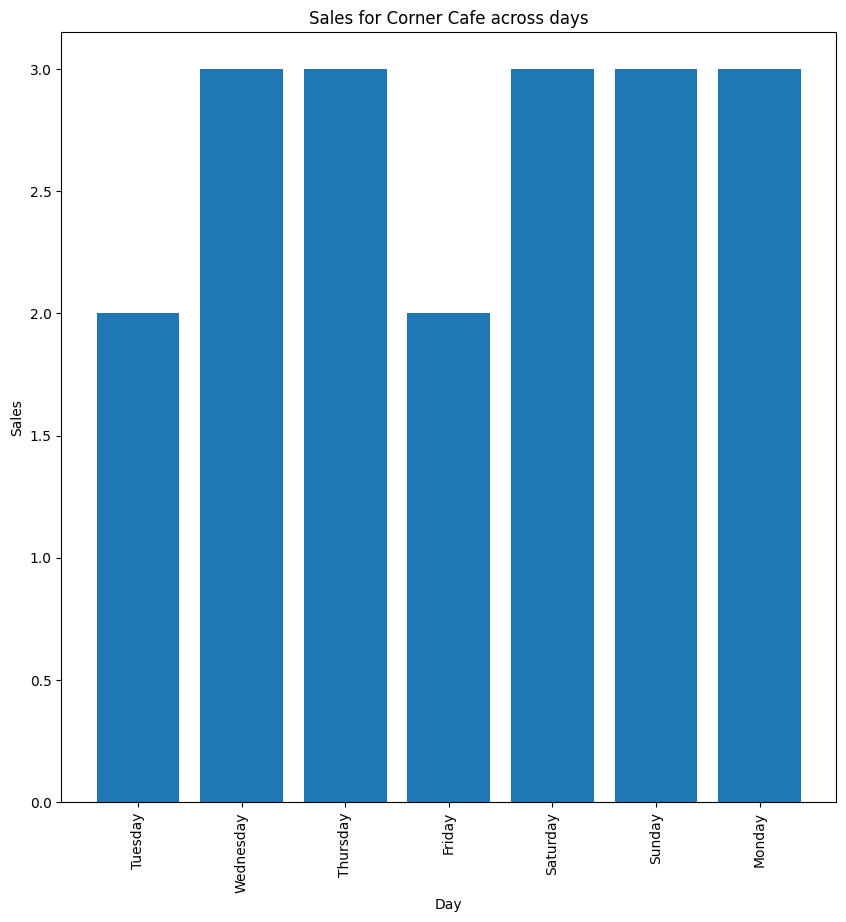

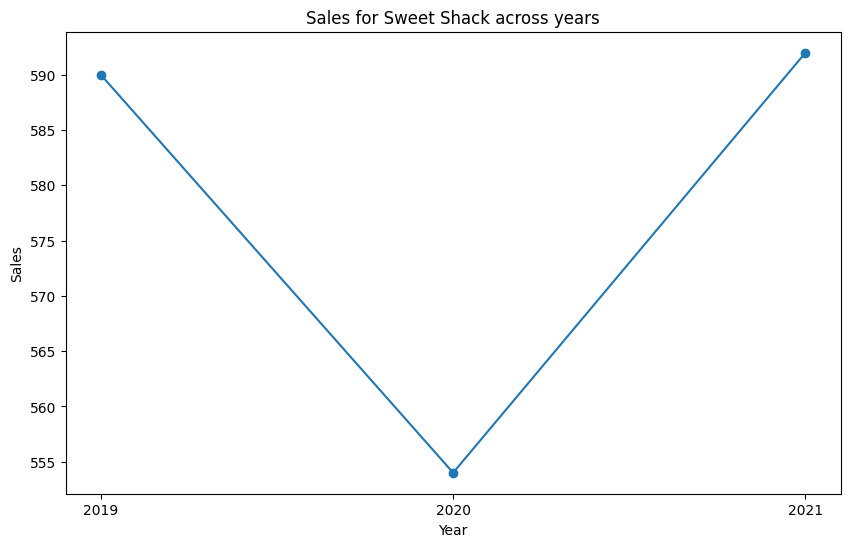

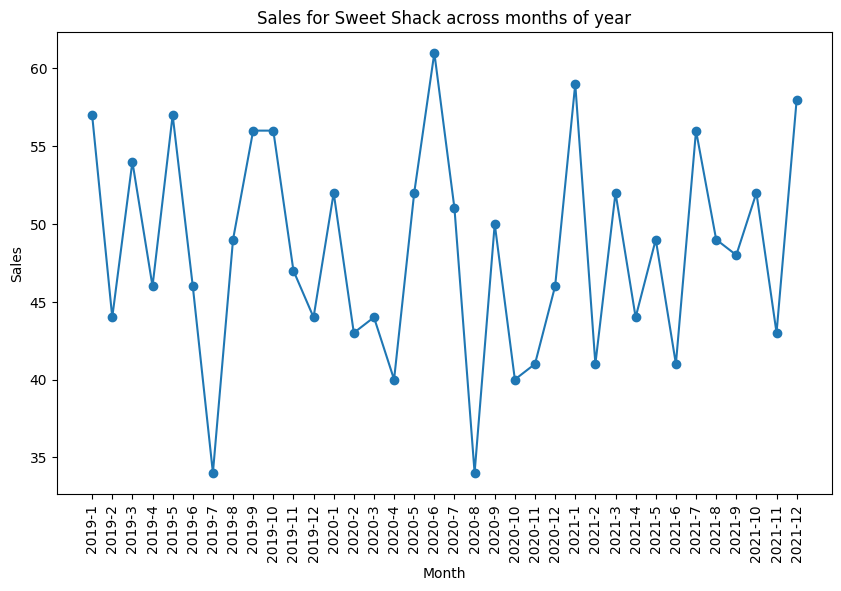

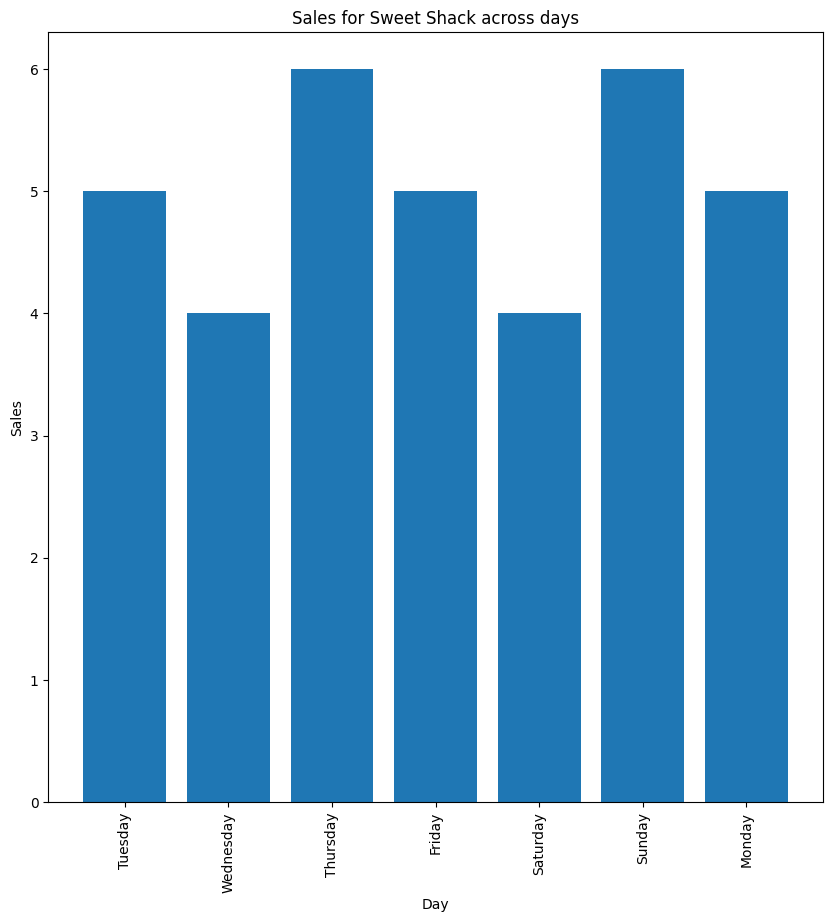

In [25]:
# Sales for each restaurant across different years, months, and days.


final_data['year'] = final_data.index.year
final_data['month'] = final_data.index.month
final_data['day'] = final_data.index.day

sales_by_year = final_data.groupby(['name_store', 'year'])['item_count'].sum().reset_index()
sales_by_month = final_data.groupby(['name_store', 'year', 'month'])['item_count'].sum().reset_index()
#sales_by_day = final_data.groupby(['name_store', 'year', 'month', 'day'])['item_count'].sum().reset_index()

day_names =list(calendar.day_name)
sales_by_day= final_data.copy()
sales_by_day['day_names'] = final_data.index.day_name()
sales_by_month['year_month'] = sales_by_month['year'].astype(str) + '-' + sales_by_month['month'].astype(str)


for store in final_data['name_store'].unique():
    store_sales_year = sales_by_year[sales_by_year['name_store'] == store]
    store_sales_month = sales_by_month[sales_by_month['name_store'] == store]
    store_sales_day = sales_by_day[sales_by_day['name_store'] == store]

    # Plot sales by year
    plt.figure(figsize=(10, 6))
    plt.plot(store_sales_year['year'].astype(str), store_sales_year['item_count'], marker='o')
    plt.title(f"Sales for {store} across years")
    plt.xlabel('Year')
    plt.ylabel('Sales')
    plt.show()

    # Plot sales by month
    plt.figure(figsize=(10, 6))
    plt.plot(store_sales_month['year_month'], store_sales_month['item_count'], marker='o')
    plt.title(f"Sales for {store} across months of year")
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.xticks(rotation=90)
    plt.show()

    # Plot sales by day
    plt.figure(figsize=(10, 10))
    plt.bar(store_sales_day['day_names'], store_sales_day['item_count'])
    plt.title(f"Sales for {store} across days")
    plt.xlabel('Day')
    plt.ylabel('Sales')
    plt.xticks(rotation=90)
    plt.show()

In [26]:
final_data.head()


item_id  price  item_count  store_id  \
date                                               
2019-01-01        3  29.22         2.0         1   
2019-01-01        4  26.42        22.0         1   
2019-01-01       12   4.87         7.0         1   
2019-01-01       13   4.18        12.0         1   
2019-01-01       16   3.21       136.0         1   

                                  name_item  kcal   name_store  year  month  \
date                                                                          
2019-01-01                Sweet Fruity Cake   931  Bob's Diner  2019      1   
2019-01-01  Amazing Steak Dinner with Rolls   763  Bob's Diner  2019      1   
2019-01-01             Fantastic Sweet Cola   478  Bob's Diner  2019      1   
2019-01-01          Sweet Frozen Soft Drink   490  Bob's Diner  2019      1   
2019-01-01             Frozen Milky Smoothy   284  Bob's Diner  2019      1   

            day  
date             
2019-01-01    1  
2019-01-01    1  
2019-01-01    1  
2019-01-01    1  
2019-01-01    1

Text(0.5, 1.0, 'Most popular item')

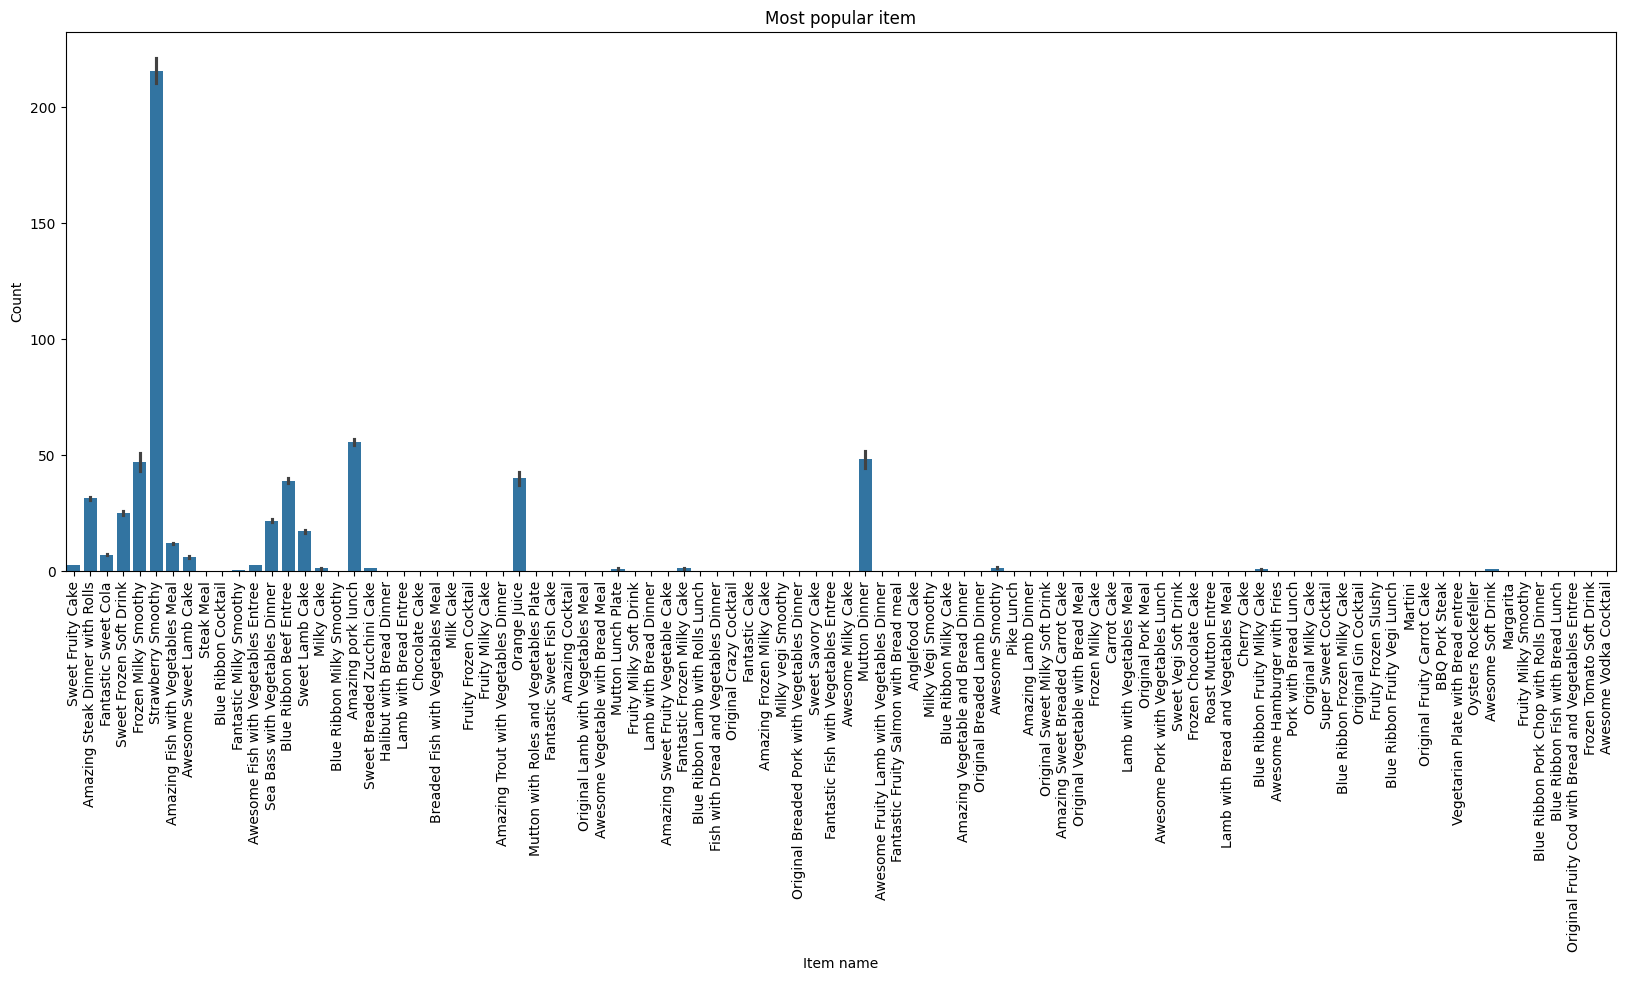

In [27]:
# Most popular item sold

plt.figure(figsize=(20,7))
sns.barplot(x=final_data['name_item'],y=final_data['item_count'])
plt.xlabel('Item name')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Most popular item')

Observation - Strawberry smoothy is the most popular item sold

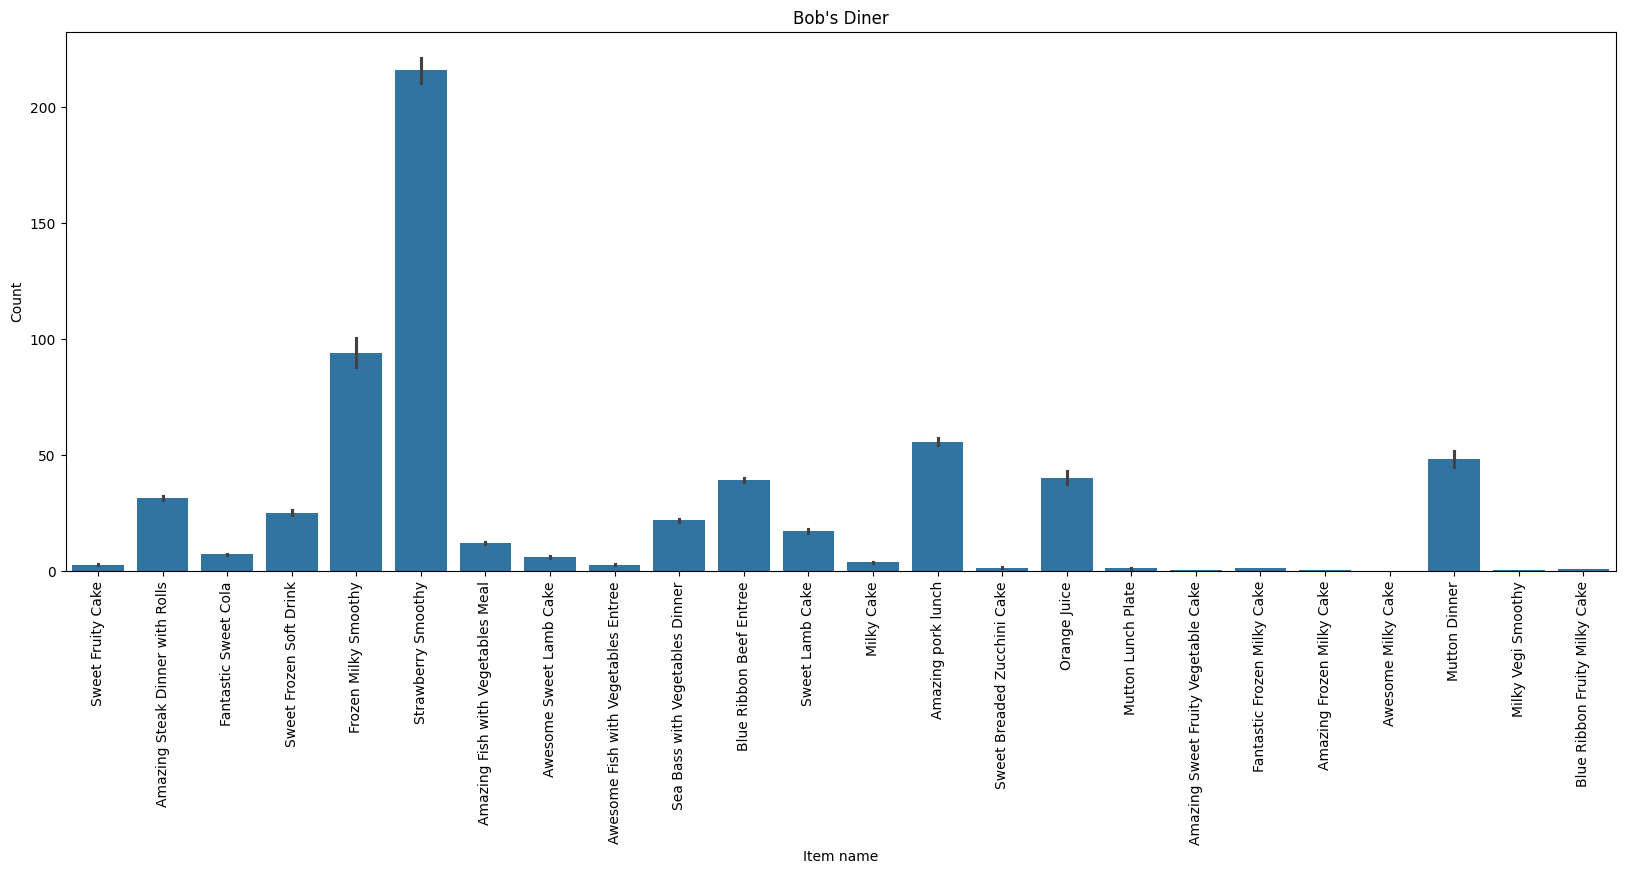

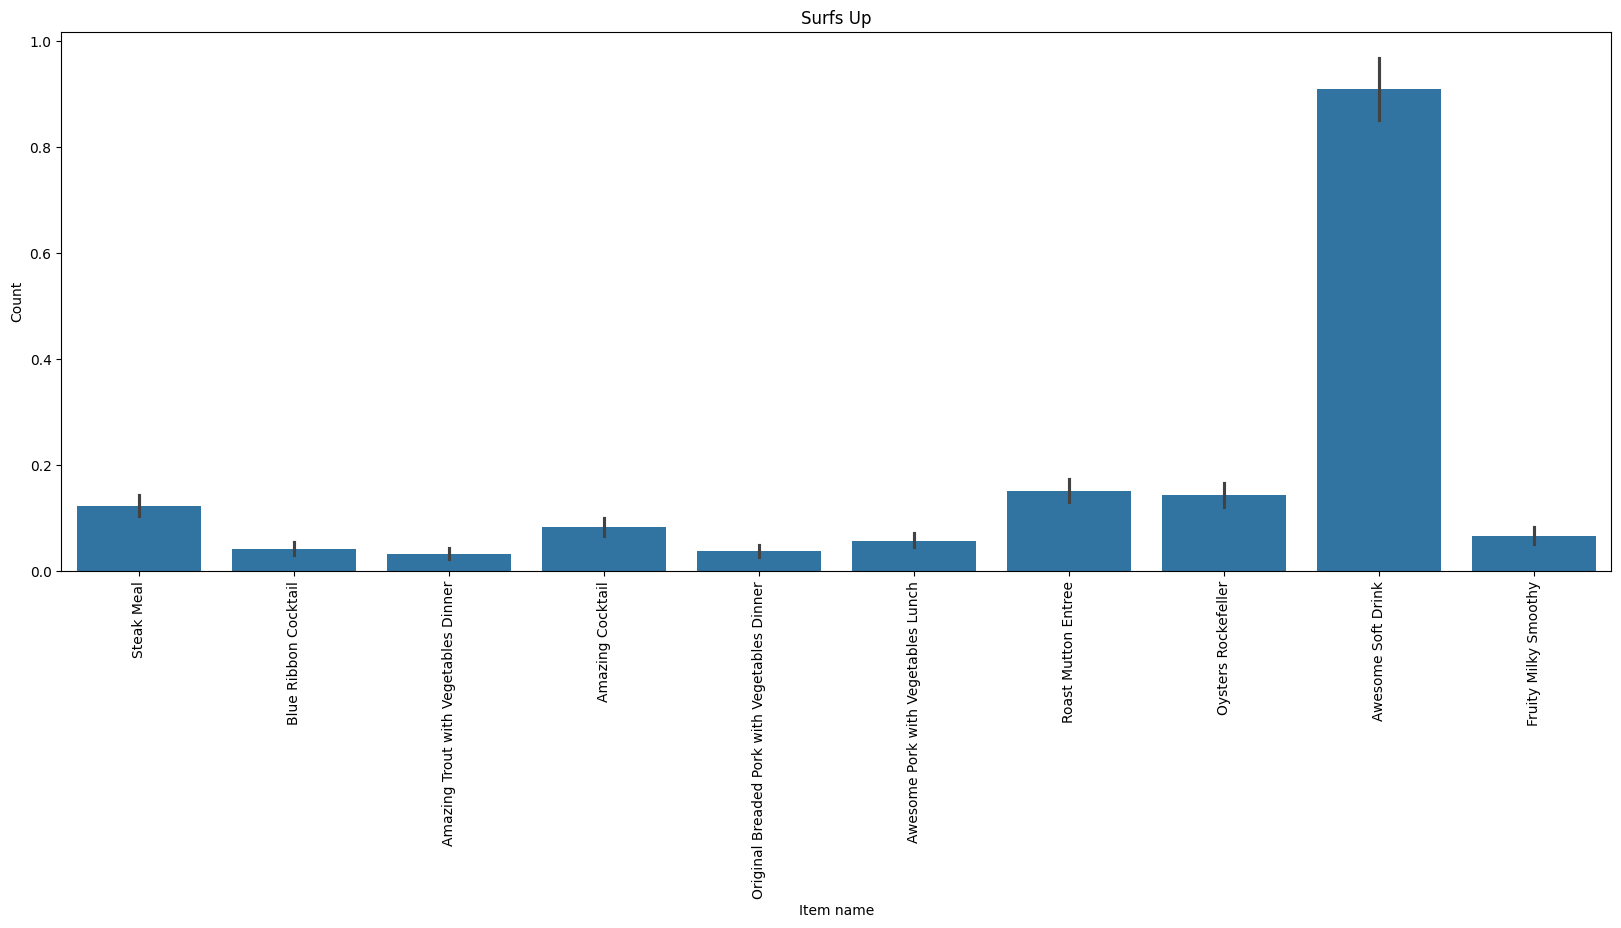

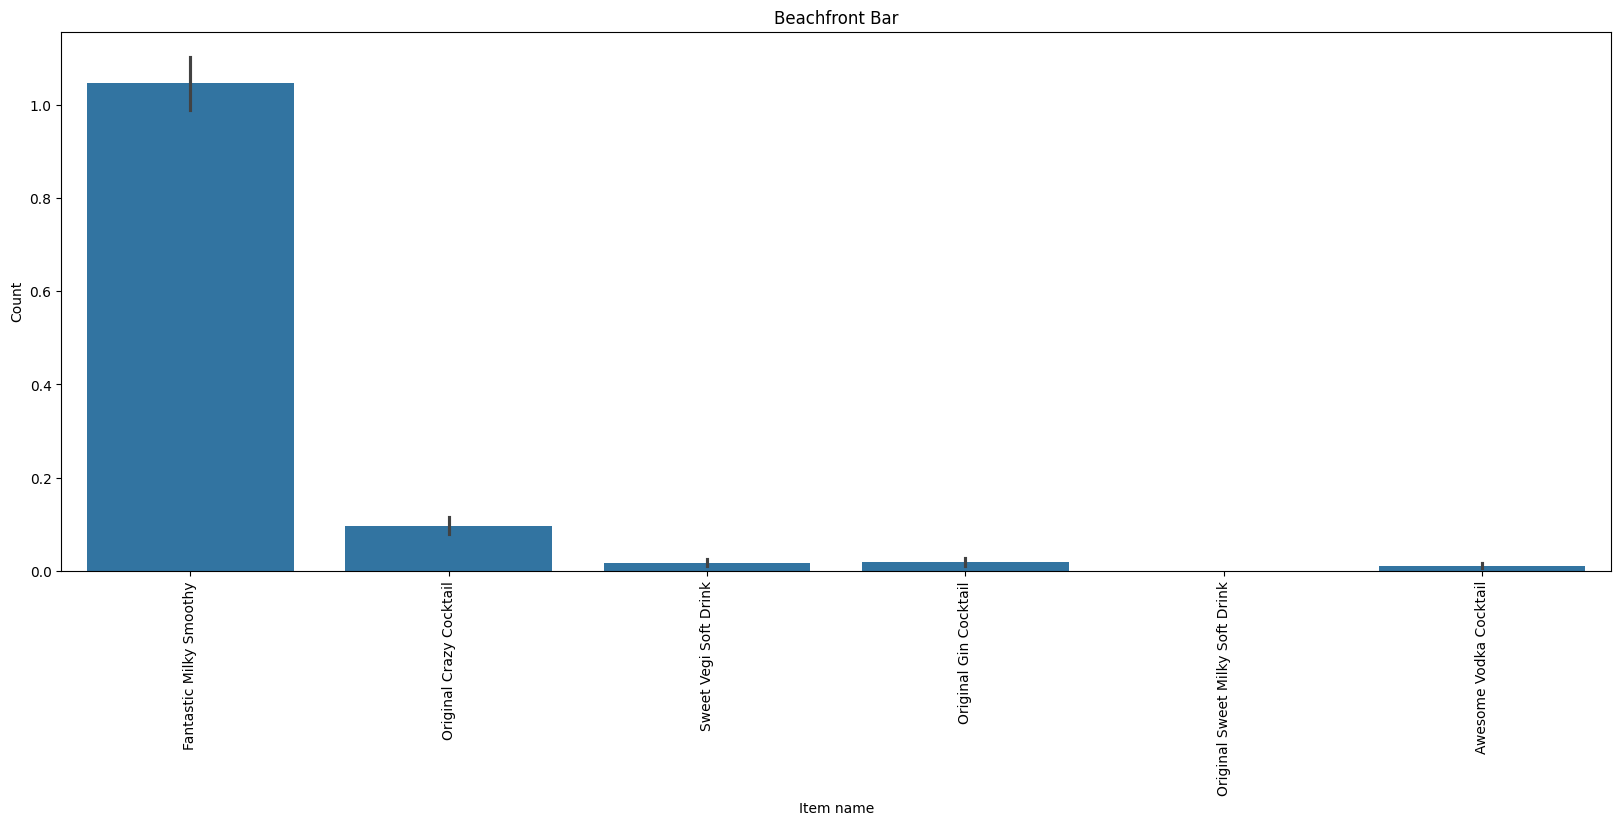

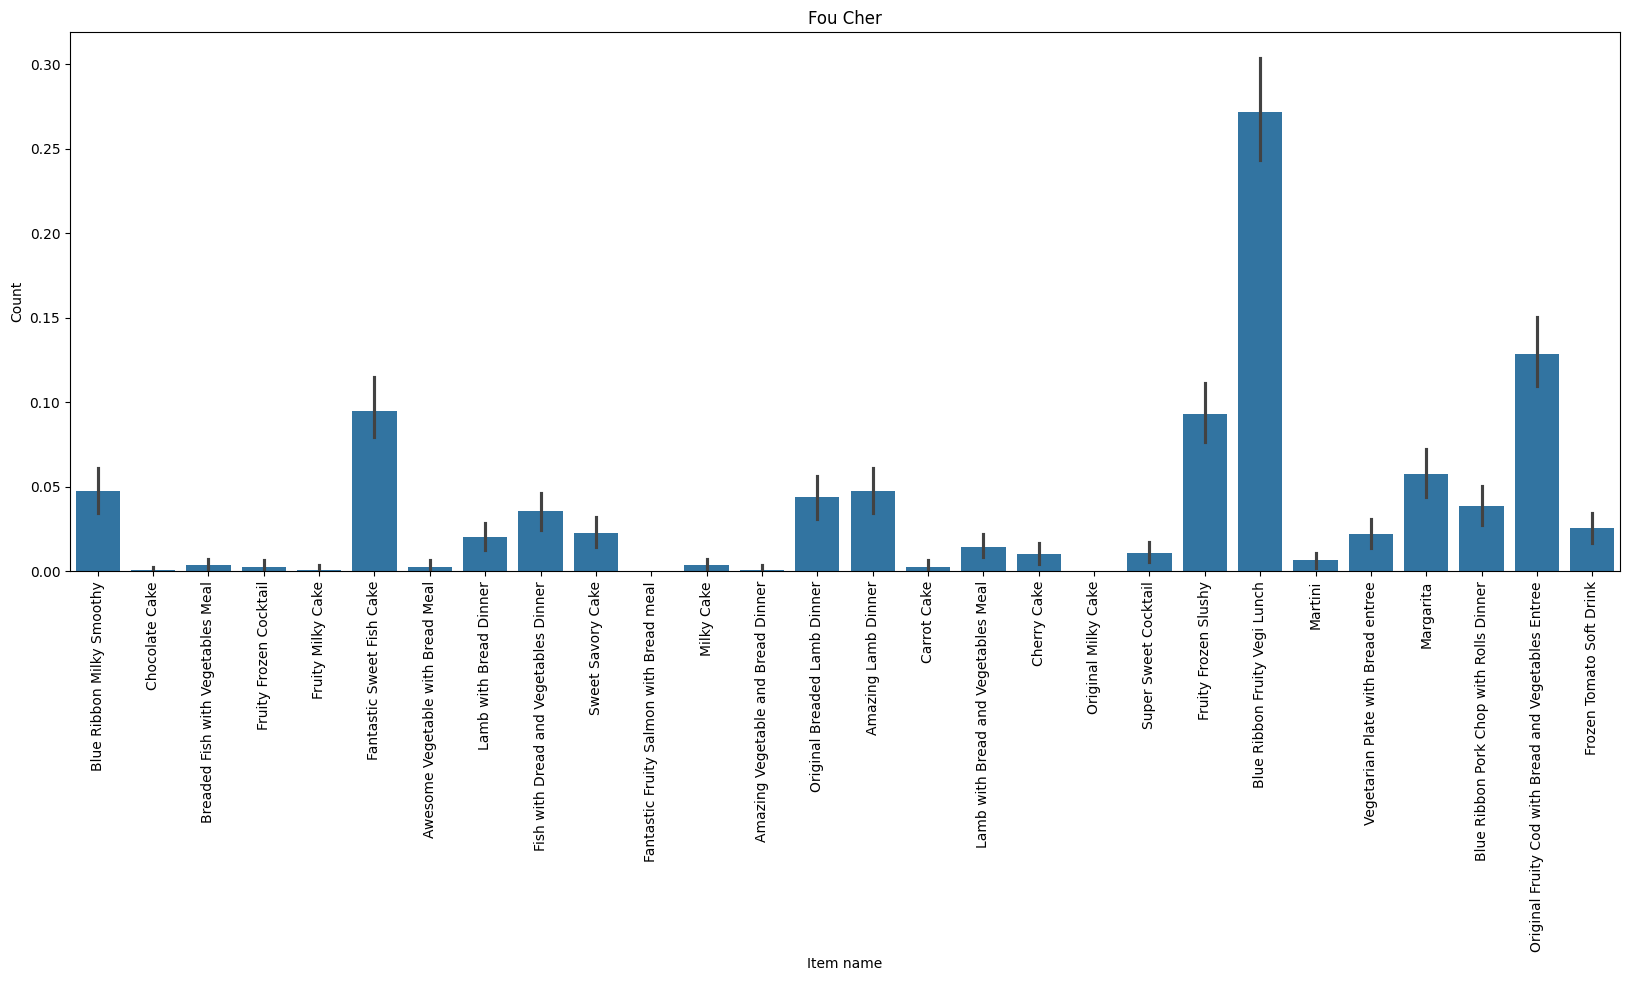

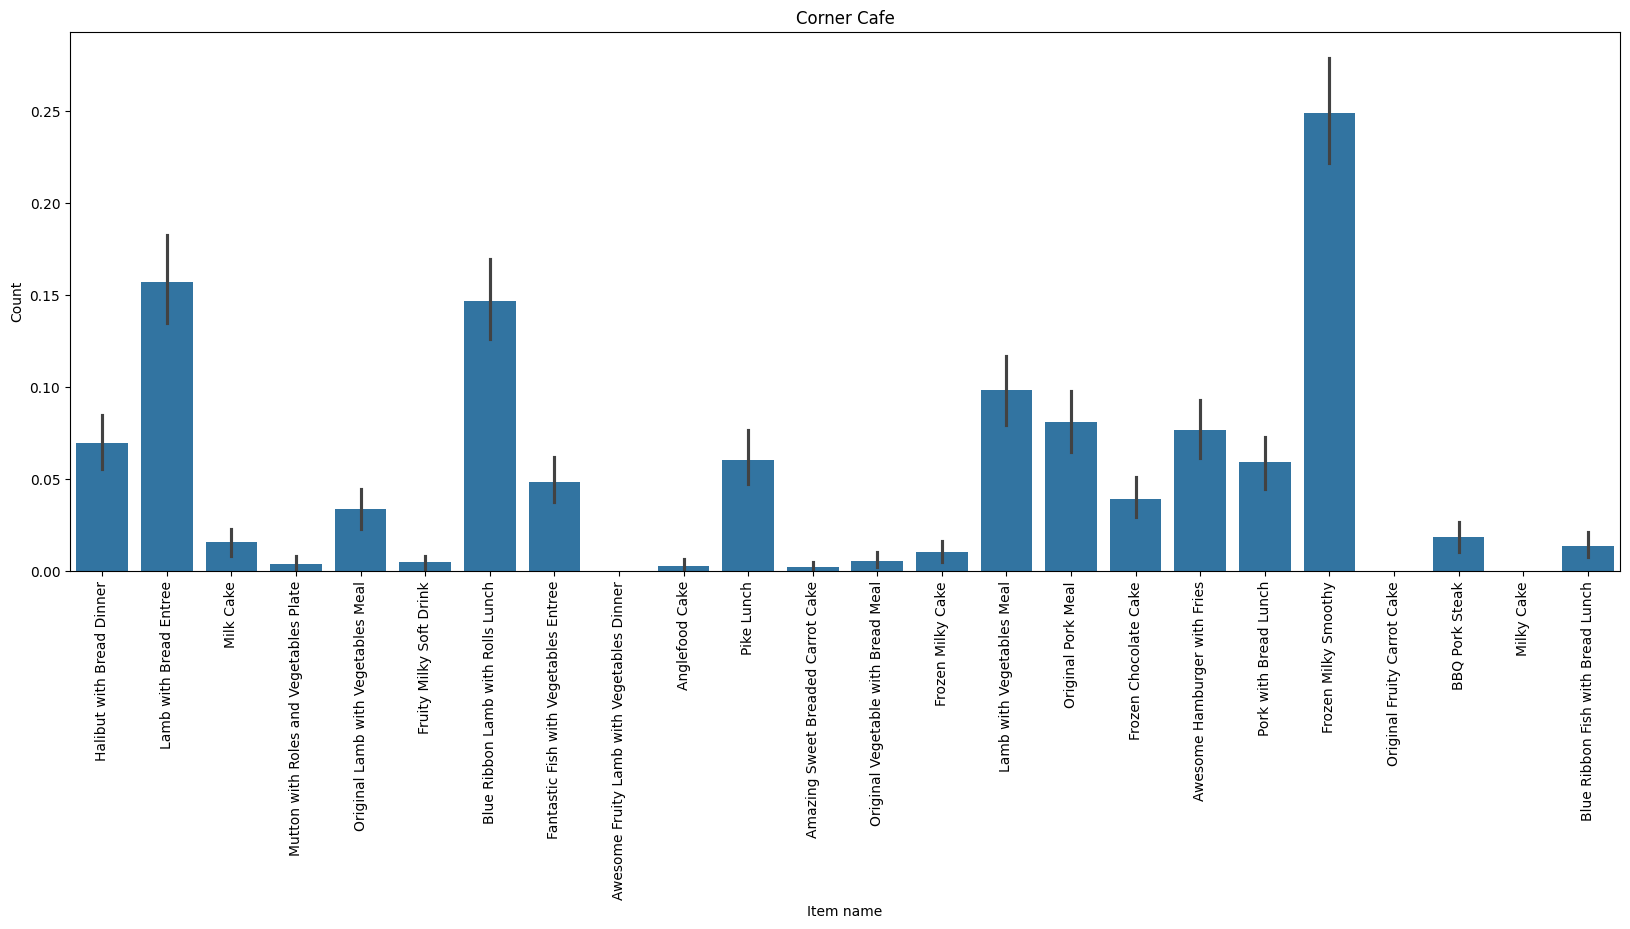

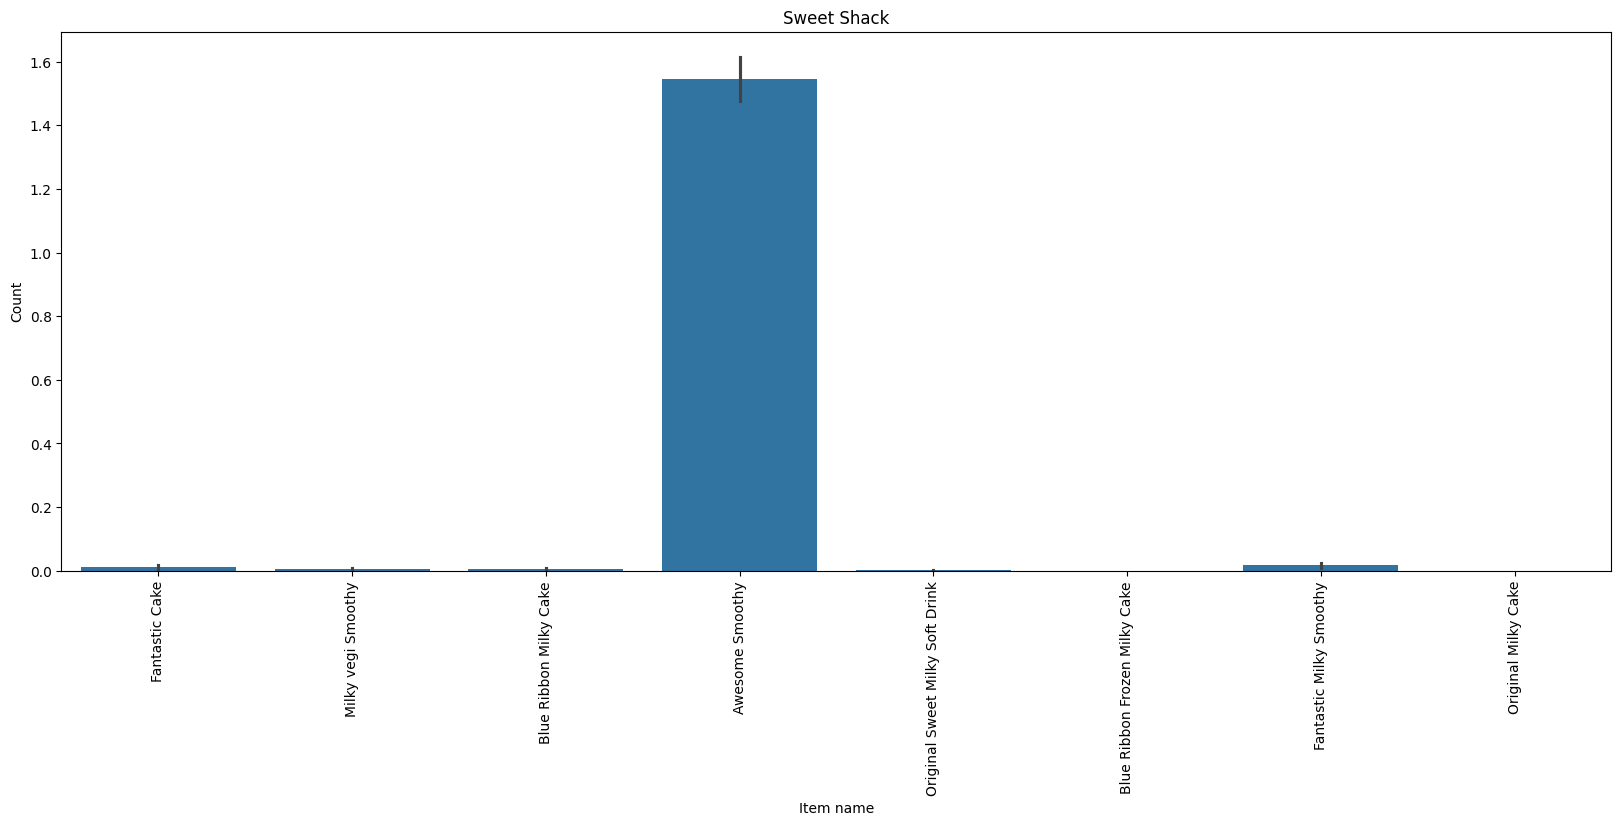

In [28]:
# Most popular item in each store
for store in final_data['name_store'].unique():
  final_data_store = final_data[final_data['name_store'] == store]
  plt.figure(figsize=(20,7))
  sns.barplot(x=final_data_store['name_item'],y=final_data_store['item_count'])
  plt.xlabel('Item name')
  plt.ylabel('Count')
  plt.xticks(rotation=90)
  plt.title(store)

In [29]:
final_data.head()

item_id  price  item_count  store_id  \
date                                               
2019-01-01        3  29.22         2.0         1   
2019-01-01        4  26.42        22.0         1   
2019-01-01       12   4.87         7.0         1   
2019-01-01       13   4.18        12.0         1   
2019-01-01       16   3.21       136.0         1   

                                  name_item  kcal   name_store  year  month  \
date                                                                          
2019-01-01                Sweet Fruity Cake   931  Bob's Diner  2019      1   
2019-01-01  Amazing Steak Dinner with Rolls   763  Bob's Diner  2019      1   
2019-01-01             Fantastic Sweet Cola   478  Bob's Diner  2019      1   
2019-01-01          Sweet Frozen Soft Drink   490  Bob's Diner  2019      1   
2019-01-01             Frozen Milky Smoothy   284  Bob's Diner  2019      1   

            day  
date             
2019-01-01    1  
2019-01-01    1  
2019-01-01    1  
2019-01-01    1  
2019-01-01    1

In [30]:
final_data['Sales'] = final_data['item_count'] * final_data['price']

Text(0.5, 1.0, 'Store with the highest volume of sales')

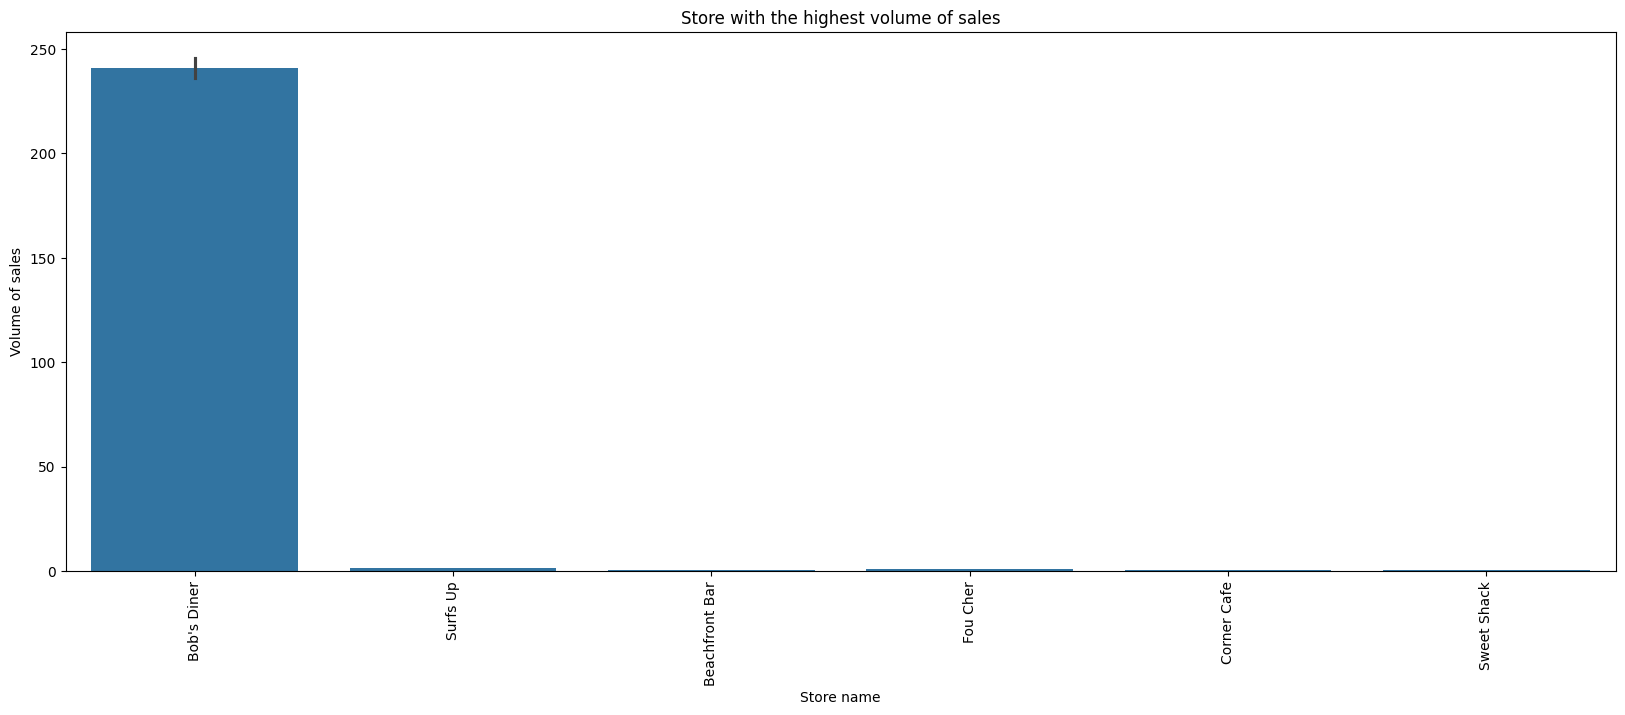

In [31]:
# Store with the highest volume of sales and revenue per day

plt.figure(figsize=(20,7))
sns.barplot(x=final_data['name_store'],y=final_data['Sales'])
plt.xlabel('Store name')
plt.ylabel('Volume of sales')
plt.xticks(rotation=90)
plt.title('Store with the highest volume of sales')

In [32]:
#Calculate total sales volume (sum of item count) per store
sales_volume_per_store = final_data.groupby('name_store')['item_count'].sum().reset_index()

#Find the store with the highest sales volume
store_highest_volume = sales_volume_per_store.loc[sales_volume_per_store['item_count'].idxmax()]

#Calculate total revenue per day per store
revenue_per_day = final_data.groupby(['name_store', final_data.index])['Sales'].sum().reset_index()

#Calculate the average daily revenue per store
avg_revenue_per_day = revenue_per_day.groupby('name_store')['Sales'].mean().reset_index()
store_highest_revenue = avg_revenue_per_day.loc[avg_revenue_per_day['Sales'].idxmax()]

#Determine if the store with the highest sales volume is the same as the store with the highest revenue
if store_highest_volume['name_store'] == store_highest_revenue['name_store']:
    print(f"The store with the highest sales volume ({store_highest_volume['name_store']}) is also making the most money per day.")
else:
    print(f"The store with the highest sales volume ({store_highest_volume['name_store']}) is NOT making the most money per day. "
          f"The store making the most money per day is {store_highest_revenue['name_store']}.")

The store with the highest sales volume (Bob's Diner) is also making the most money per day.


In [33]:
most_expensive_items = items_data.loc[items_data.groupby('store_id')['cost'].idxmax()]
print(most_expensive_items)

    id  store_id                           name  kcal   cost
2    3         1              Sweet Fruity Cake   931  29.22
61  62         2          Sweet Vegi Soft Drink   538   5.70
76  77         3  Blue Ribbon Frozen Milky Cake   636   7.70
79  80         4  Blue Ribbon Fruity Vegi Lunch   881  53.98
49  50         5                     Pike Lunch   653  26.37
26  27         6                     Steak Meal   607  26.21


## Fitting the data into ML models

In [34]:
final_data.head()

item_id  price  item_count  store_id  \
date                                               
2019-01-01        3  29.22         2.0         1   
2019-01-01        4  26.42        22.0         1   
2019-01-01       12   4.87         7.0         1   
2019-01-01       13   4.18        12.0         1   
2019-01-01       16   3.21       136.0         1   

                                  name_item  kcal   name_store  year  month  \
date                                                                          
2019-01-01                Sweet Fruity Cake   931  Bob's Diner  2019      1   
2019-01-01  Amazing Steak Dinner with Rolls   763  Bob's Diner  2019      1   
2019-01-01             Fantastic Sweet Cola   478  Bob's Diner  2019      1   
2019-01-01          Sweet Frozen Soft Drink   490  Bob's Diner  2019      1   
2019-01-01             Frozen Milky Smoothy   284  Bob's Diner  2019      1   

            day   Sales  
date                     
2019-01-01    1   58.44  
2019-01-01    1  581.24  
2019-01-01    1   34.09  
2019-01-01    1   50.16  
2019-01-01    1  436.56

In [35]:
final_data_ts = final_data.groupby(['date']).agg({'item_count':'sum', 'year': lambda x :x.unique()[0],
                            'month' : lambda x :x.unique()[0], 'day': lambda x :x.unique()[0]
                                          })

In [36]:
final_data_ts

item_count  year  month  day
date                                    
2019-01-01       427.0  2019      1    1
2019-01-02       337.0  2019      1    2
2019-01-03       445.0  2019      1    3
2019-01-04       564.0  2019      1    4
2019-01-05       552.0  2019      1    5
...                ...   ...    ...  ...
2021-12-27       192.0  2021     12   27
2021-12-28       344.0  2021     12   28
2021-12-29       371.0  2021     12   29
2021-12-30       527.0  2021     12   30
2021-12-31       817.0  2021     12   31

[1096 rows x 4 columns]

In [37]:
# Including more features to the data

final_data_ts['week_num'] = final_data_ts.index.isocalendar().week.astype(int)
#final_data_ts['is_weekend'] = final_data_ts['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
final_data_ts['quarter'] = final_data_ts.index.quarter
final_data_ts['day_year'] = final_data_ts.index.day_of_year
final_data_ts['weekday'] = final_data_ts.index.day_of_week
final_data_ts['day_of_week'] = final_data_ts.index.day_name()

In [38]:
final_data_ts.head()

item_count  year  month  day  week_num  quarter  day_year  \
date                                                                    
2019-01-01       427.0  2019      1    1         1        1         1   
2019-01-02       337.0  2019      1    2         1        1         2   
2019-01-03       445.0  2019      1    3         1        1         3   
2019-01-04       564.0  2019      1    4         1        1         4   
2019-01-05       552.0  2019      1    5         1        1         5   

            weekday day_of_week  
date                             
2019-01-01        1     Tuesday  
2019-01-02        2   Wednesday  
2019-01-03        3    Thursday  
2019-01-04        4      Friday  
2019-01-05        5    Saturday

In [39]:
# Ordinal encoding for catagorical features

from sklearn.preprocessing import OrdinalEncoder

day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

ord_enc = OrdinalEncoder(categories = [day_of_week])
ord_enc.fit(final_data_ts[['day_of_week']])
final_data_ts[['day_of_week']] = ord_enc.transform(final_data_ts[['day_of_week']])


In [40]:
final_data_ts.head()

item_count  year  month  day  week_num  quarter  day_year  \
date                                                                    
2019-01-01       427.0  2019      1    1         1        1         1   
2019-01-02       337.0  2019      1    2         1        1         2   
2019-01-03       445.0  2019      1    3         1        1         3   
2019-01-04       564.0  2019      1    4         1        1         4   
2019-01-05       552.0  2019      1    5         1        1         5   

            weekday  day_of_week  
date                              
2019-01-01        1          1.0  
2019-01-02        2          2.0  
2019-01-03        3          3.0  
2019-01-04        4          4.0  
2019-01-05        5          5.0

In [41]:
final_data_ts = final_data_ts.sort_index()

# Define the cutoff date for the last 6 months of data
cutoff_date = final_data_ts.index[-1] - pd.DateOffset(months=6)

# Split the data
test_data = final_data_ts[final_data_ts.index >= cutoff_date]  # Last 6 months
train_data = final_data_ts[final_data_ts.index < cutoff_date]    # Earlier data

# Separate features and target (Sales)
X_train = train_data.drop(columns=['item_count'])
y_train = train_data['item_count']

X_test = test_data.drop(columns=['item_count'])
y_test = test_data['item_count']

In [42]:
X_train

year  month  day  week_num  quarter  day_year  weekday  \
date                                                                 
2019-01-01  2019      1    1         1        1         1        1   
2019-01-02  2019      1    2         1        1         2        2   
2019-01-03  2019      1    3         1        1         3        3   
2019-01-04  2019      1    4         1        1         4        4   
2019-01-05  2019      1    5         1        1         5        5   
...          ...    ...  ...       ...      ...       ...      ...   
2021-06-25  2021      6   25        25        2       176        4   
2021-06-26  2021      6   26        25        2       177        5   
2021-06-27  2021      6   27        25        2       178        6   
2021-06-28  2021      6   28        26        2       179        0   
2021-06-29  2021      6   29        26        2       180        1   

            day_of_week  
date                     
2019-01-01          1.0  
2019-01-02          2.0  
2019-01-03          3.0  
2019-01-04          4.0  
2019-01-05          5.0  
...                 ...  
2021-06-25          4.0  
2021-06-26          5.0  
2021-06-27          6.0  
2021-06-28          0.0  
2021-06-29          1.0  

[911 rows x 8 columns]

In [43]:
# Scaling the data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
test_data.head()

item_count  year  month  day  week_num  quarter  day_year  \
date                                                                    
2021-06-30       866.0  2021      6   30        26        2       181   
2021-07-01      1070.0  2021      7    1        26        3       182   
2021-07-02      1167.0  2021      7    2        26        3       183   
2021-07-03      1132.0  2021      7    3        26        3       184   
2021-07-04       677.0  2021      7    4        26        3       185   

            weekday  day_of_week  
date                              
2021-06-30        2          2.0  
2021-07-01        3          3.0  
2021-07-02        4          4.0  
2021-07-03        5          5.0  
2021-07-04        6          6.0

In [45]:
# Initializing and fitting the linear regression model

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predicting based on the test data
y_pred = model.predict(X_test_scaled)
test_data['lr_predict'] = y_pred

#Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 59274.284331830524
R-squared: 0.08012611199423392


In [46]:
test_data

item_count  year  month  day  week_num  quarter  day_year  \
date                                                                    
2021-06-30       866.0  2021      6   30        26        2       181   
2021-07-01      1070.0  2021      7    1        26        3       182   
2021-07-02      1167.0  2021      7    2        26        3       183   
2021-07-03      1132.0  2021      7    3        26        3       184   
2021-07-04       677.0  2021      7    4        26        3       185   
...                ...   ...    ...  ...       ...      ...       ...   
2021-12-27       192.0  2021     12   27        52        4       361   
2021-12-28       344.0  2021     12   28        52        4       362   
2021-12-29       371.0  2021     12   29        52        4       363   
2021-12-30       527.0  2021     12   30        52        4       364   
2021-12-31       817.0  2021     12   31        52        4       365   

            weekday  day_of_week  lr_predict  
date                                          
2021-06-30        2          2.0  737.630527  
2021-07-01        3          3.0  805.046425  
2021-07-02        4          4.0  839.753624  
2021-07-03        5          5.0  874.460824  
2021-07-04        6          6.0  909.168023  
...             ...          ...         ...  
2021-12-27        0          0.0  660.661282  
2021-12-28        1          1.0  695.368481  
2021-12-29        2          2.0  730.075681  
2021-12-30        3          3.0  764.782880  
2021-12-31        4          4.0  799.490080  

[185 rows x 10 columns]

In [47]:
lr_rmse = mean_squared_error(y_true = test_data.item_count, y_pred = test_data.lr_predict, squared = False)
lr_mae = mean_absolute_error(y_true = test_data.item_count, y_pred = test_data.lr_predict)
lr_r2_score = r2_score(y_true = test_data.item_count, y_pred = test_data.lr_predict)
print("Linear Regression :\nRMSE : {:.2f}\nMAE : {:.2f}\nR2_Score : {:.2f}".format(lr_rmse,lr_mae,lr_r2_score*100))

Linear Regression :
RMSE : 243.46
MAE : 195.48
R2_Score : 8.01


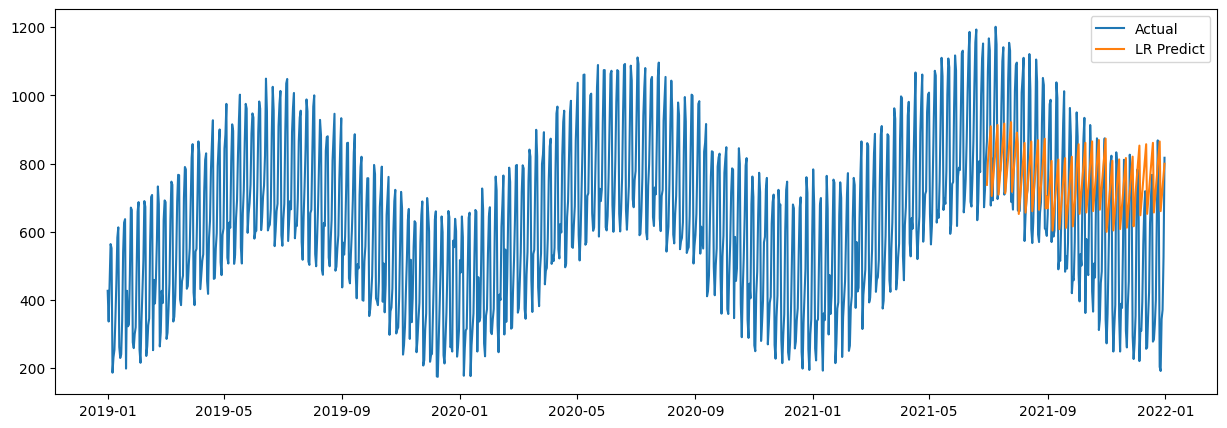

In [48]:
plt.figure(figsize = (15,5))
plt.plot(final_data_ts.item_count, label = "Actual")
plt.plot(test_data.lr_predict, label = "LR Predict")
plt.legend()
plt.show()

In [49]:
results = pd.DataFrame([lr_rmse, lr_mae,lr_r2_score*100], index = ['RMSE', 'MAE', 'R2_Score'], columns = ['Linear Regression']).round(2)
results

Linear Regression
RMSE                 243.46
MAE                  195.48
R2_Score               8.01

In [50]:
#Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42,max_depth=20)

rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
test_data['rf_predict'] = y_pred_rf

# Evaluate the model performance
mse_rf = mean_squared_error(y_test, y_pred_rf,squared= False)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - Mean Absolute Error: {mae_rf}")
print(f"Random Forest - R-squared: {r2_rf}")

Random Forest - Mean Squared Error: 59.90833624706909
Random Forest - Mean Absolute Error: 47.778864864864865
Random Forest - R-squared: 0.9443023990604871


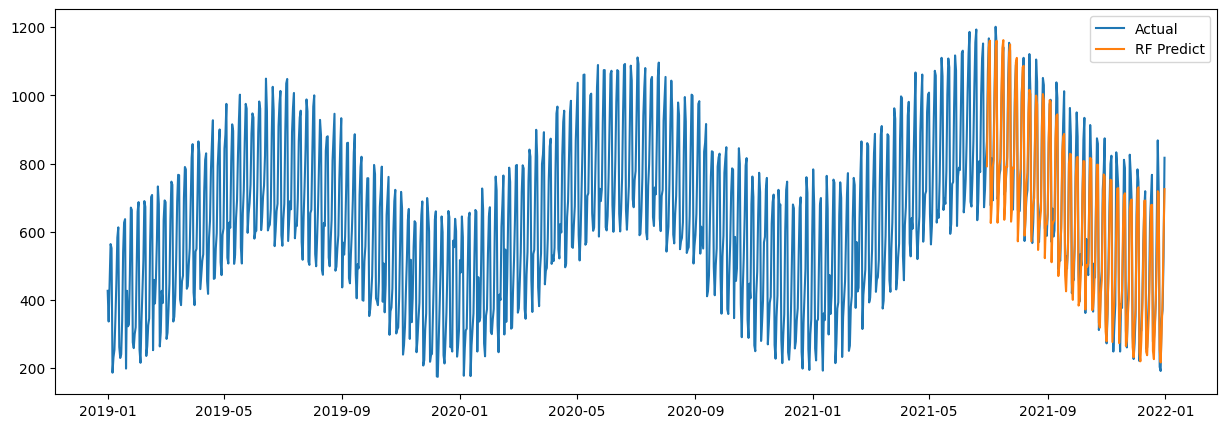

In [51]:
plt.figure(figsize = (15,5))
plt.plot(final_data_ts.item_count, label = "Actual")
plt.plot(test_data.rf_predict, label = "RF Predict")
plt.legend()
plt.show()

In [52]:
results['Random Forest'] = [mse_rf,mae_rf,r2_rf*100]
results.round(2)

Linear Regression  Random Forest
RMSE                 243.46          59.91
MAE                  195.48          47.78
R2_Score               8.01          94.43

In [53]:
#  Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01,max_depth=3, random_state=42)

xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)
test_data['xgb_predict'] = y_pred_xgb

# Evaluate the model performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb,squared=False)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - Mean Squared Error: {mse_xgb}")
print(f"XGBoost - Mean Absolute Error: {mae_xgb}")
print(f"XGBoost - R-squared: {r2_xgb}")

XGBoost - Mean Squared Error: 78.0472967858947
XGBoost - Mean Absolute Error: 64.08655197555954
XGBoost - R-squared: 0.905468248840877


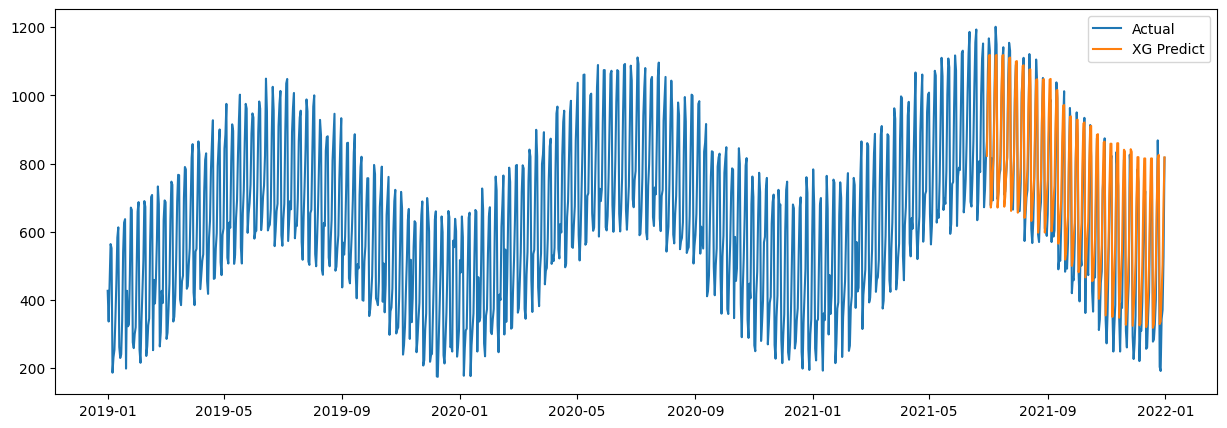

In [55]:
plt.figure(figsize = (15,5))
plt.plot(final_data_ts.item_count, label = "Actual")
plt.plot(test_data.xgb_predict, label = "XG Predict")
plt.legend()
plt.show()

In [56]:
results['XGBoost'] = [mse_xgb,mae_xgb,r2_xgb*100]
results.round(2)

Linear Regression  Random Forest  XGBoost
RMSE                 243.46          59.91    78.05
MAE                  195.48          47.78    64.09
R2_Score               8.01          94.43    90.55

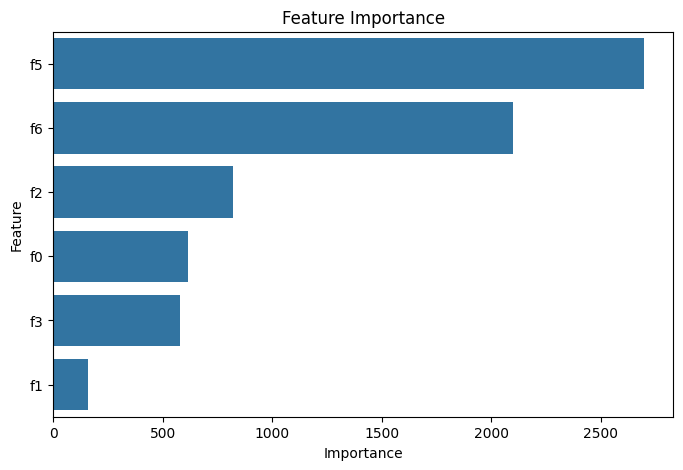

{'f0': 617.0, 'f1': 157.0, 'f2': 819.0, 'f3': 580.0, 'f5': 2696.0, 'f6': 2098.0}


In [57]:
importance = xgb_model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'feature': importance.keys(),
    'importance': importance.values()
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
#plt.set_yticklabels(X_train.columns)
plt.show()
print(importance)

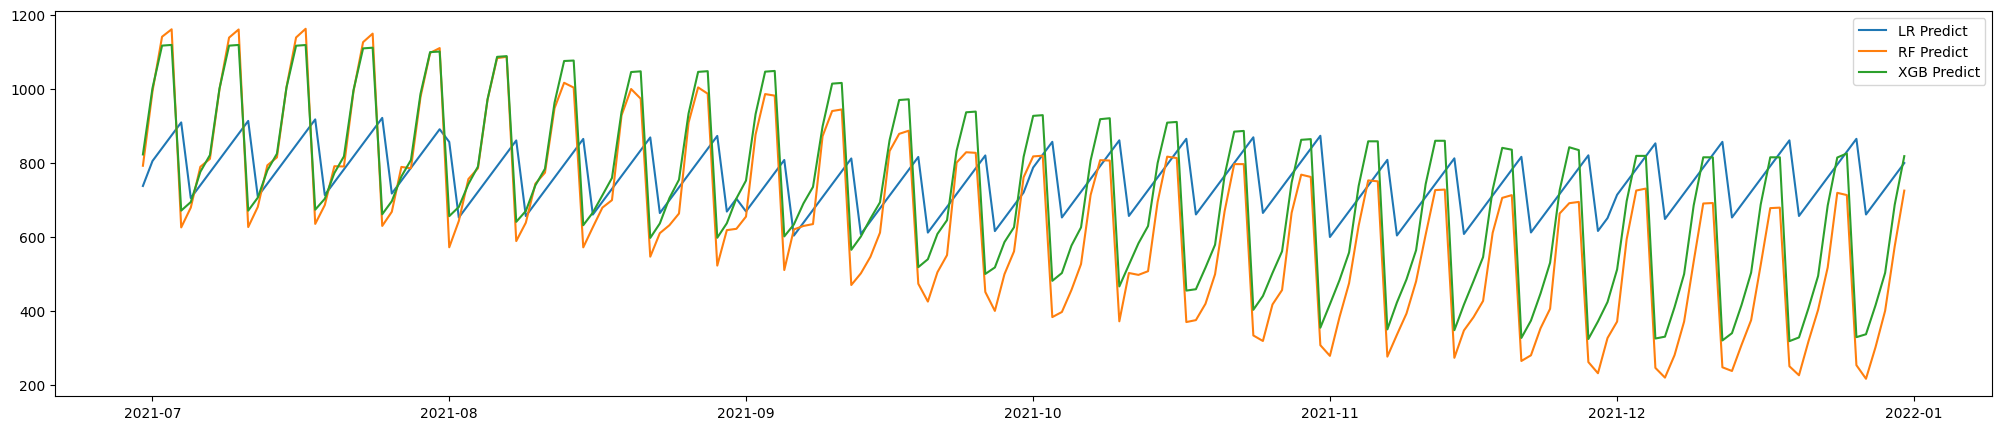

In [58]:
plt.figure(figsize = (25,5))
plt.plot(test_data.lr_predict, label = "LR Predict")
plt.plot(test_data.rf_predict, label = "RF Predict")
plt.plot(test_data.xgb_predict, label = "XGB Predict")
plt.legend()
plt.show()

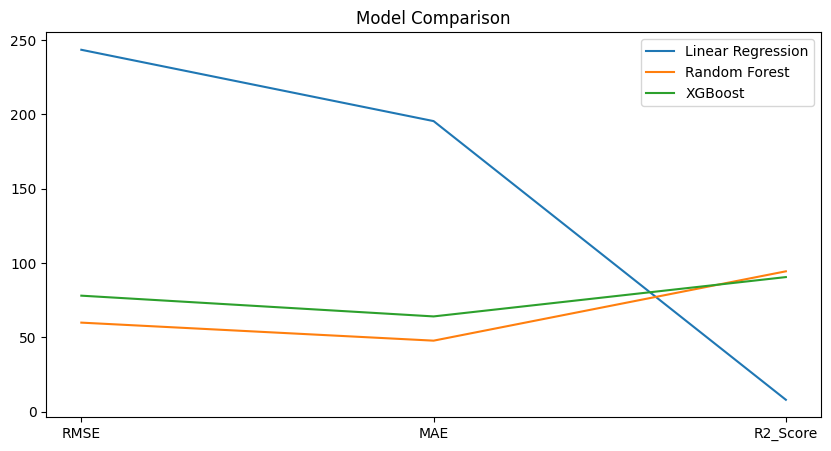

In [59]:
plt.figure(figsize = (10,5))
plt.plot(results['Linear Regression'], label = "Linear Regression")
plt.plot(results['Random Forest'], label = "Random Forest")
plt.plot(results['XGBoost'], label = "XGBoost")
plt.legend(loc = "upper right")
plt.title("Model Comparison")
plt.show()

## Generating future data

In [60]:
X_train.head()

year  month  day  week_num  quarter  day_year  weekday  \
date                                                                 
2019-01-01  2019      1    1         1        1         1        1   
2019-01-02  2019      1    2         1        1         2        2   
2019-01-03  2019      1    3         1        1         3        3   
2019-01-04  2019      1    4         1        1         4        4   
2019-01-05  2019      1    5         1        1         5        5   

            day_of_week  
date                     
2019-01-01          1.0  
2019-01-02          2.0  
2019-01-03          3.0  
2019-01-04          4.0  
2019-01-05          5.0

In [61]:
future_data=[]

In [93]:
#Generate future dates for the next year
future_dates = pd.date_range(start=final_data.index[-1] + pd.DateOffset(days=1), periods=365, freq='D')

# Create a new dataframe with future dates
future_data = pd.DataFrame(index=future_dates)

future_data['year'] = future_data.index.year
future_data['month'] = future_data.index.month
future_data['day'] = future_data.index.day
future_data['week_num'] = future_data.index.isocalendar().week.astype(int)
future_data['quarter'] = future_data.index.quarter
future_data['day_year'] = future_data.index.day_of_year
future_data['weekday'] = future_data.index.day_of_week
future_data['day_of_week'] = future_data.index.day_name()

future_data.head()



year  month  day  week_num  quarter  day_year  weekday day_of_week
2022-01-01  2022      1    1        52        1         1        5    Saturday
2022-01-02  2022      1    2        52        1         2        6      Sunday
2022-01-03  2022      1    3         1        1         3        0      Monday
2022-01-04  2022      1    4         1        1         4        1     Tuesday
2022-01-05  2022      1    5         1        1         5        2   Wednesday

In [64]:
#X_future = pd.get_dummies(X_future, columns=['name_store', 'name_item'], drop_first=True)

future_data[['day_of_week']] = ord_enc.transform(future_data[['day_of_week']])

In [65]:
future_data.head()

year  month  day  week_num  quarter  day_year  weekday  \
2022-01-01  2022      1    1        52        1         1        5   
2022-01-02  2022      1    2        52        1         2        6   
2022-01-03  2022      1    3         1        1         3        0   
2022-01-04  2022      1    4         1        1         4        1   
2022-01-05  2022      1    5         1        1         5        2   

            day_of_week  
2022-01-01          5.0  
2022-01-02          6.0  
2022-01-03          0.0  
2022-01-04          1.0  
2022-01-05          2.0

In [66]:
# Predicting the future using Random forest

# Optionally scale features if needed (use the same scaler as before)
future_data_scaled = scaler.transform(future_data)

# As the RF model gave the best results using it to predict the future data
# Add the predictions to the future_data dataframe
future_data['predictions'] = rf_model.predict(future_data_scaled)

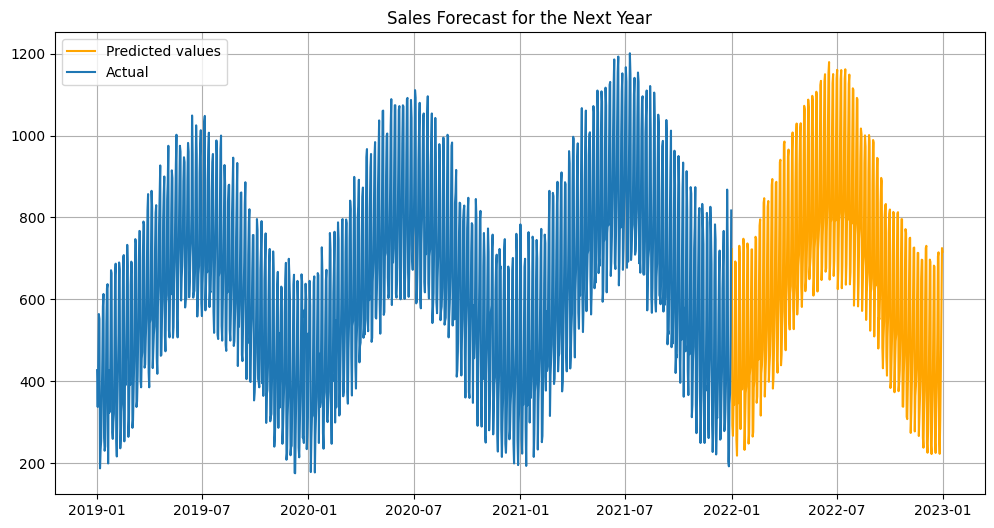

In [67]:
# Visualising the future data

plt.figure(figsize=(12, 6))
plt.plot(future_data.predictions, label='Predicted values', color='orange')
plt.plot(final_data_ts.item_count, label = "Actual")
plt.title('Sales Forecast for the Next Year')

plt.legend()
plt.grid()
plt.show()

## Building LSTM model for predictions

In [68]:
final_data.head()

item_id  price  item_count  store_id  \
date                                               
2019-01-01        3  29.22         2.0         1   
2019-01-01        4  26.42        22.0         1   
2019-01-01       12   4.87         7.0         1   
2019-01-01       13   4.18        12.0         1   
2019-01-01       16   3.21       136.0         1   

                                  name_item  kcal   name_store  year  month  \
date                                                                          
2019-01-01                Sweet Fruity Cake   931  Bob's Diner  2019      1   
2019-01-01  Amazing Steak Dinner with Rolls   763  Bob's Diner  2019      1   
2019-01-01             Fantastic Sweet Cola   478  Bob's Diner  2019      1   
2019-01-01          Sweet Frozen Soft Drink   490  Bob's Diner  2019      1   
2019-01-01             Frozen Milky Smoothy   284  Bob's Diner  2019      1   

            day   Sales  
date                     
2019-01-01    1   58.44  
2019-01-01    1  581.24  
2019-01-01    1   34.09  
2019-01-01    1   50.16  
2019-01-01    1  436.56

In [69]:
final_data_timeseries = final_data.groupby(['date']).agg({'Sales':'sum'})
print(final_data_timeseries)

              Sales
date               
2019-01-01  4023.00
2019-01-02  3074.69
2019-01-03  4062.71
2019-01-04  5006.81
2019-01-05  4927.53
...             ...
2021-12-27  1867.71
2021-12-28  3426.50
2021-12-29  3715.39
2021-12-30  5266.27
2021-12-31  8287.81

[1096 rows x 1 columns]


In [70]:
# define the train and test series
test_data = final_data_timeseries[final_data_timeseries.index >= cutoff_date]  # Last 6 months
train_data = final_data_timeseries[final_data_timeseries.index < cutoff_date]    # Earlier data


In [71]:
# Normalizing the  data

scaler = MinMaxScaler()
scaler.fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)


In [72]:


n_features = 1
length = 12 # Timesteps

generator = TimeseriesGenerator(train_scaled, train_scaled, length=length, batch_size=1)


## Buiding LSTM model

In [73]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [74]:
validation_generator = TimeseriesGenerator(test_scaled,test_scaled, length=length, batch_size=1)

In [75]:
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0490 - val_loss: 0.0177
Epoch 2/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0115 - val_loss: 0.0239
Epoch 3/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0101 - val_loss: 0.0090
Epoch 4/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0079 - val_loss: 0.0056
Epoch 5/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0063 - val_loss: 0.0043
Epoch 6/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 7/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 8/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0038 - val_loss: 0.0070


<Axes: >

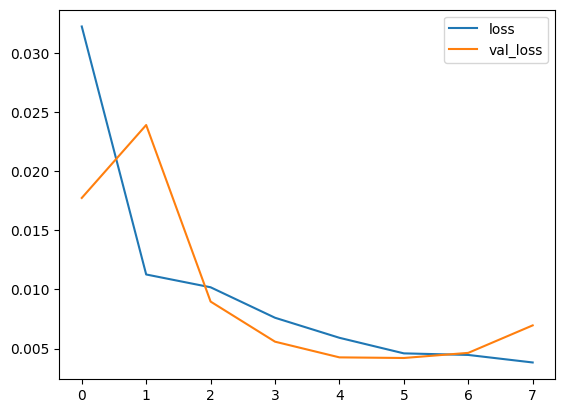

In [76]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [77]:
# Evaluate the predictions on batches

test_predictions = []
first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test_data)):
    current_pred = model.predict(current_batch)[0]
    # store prediction
    test_predictions.append(current_pred)
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

In [78]:
# Inverse scaling
true_predictions = scaler.inverse_transform(test_predictions)
test_data['Predictions'] = true_predictions

In [79]:
test_data

Sales  Predictions
date                             
2021-06-30   8198.43  7612.244585
2021-07-01  10290.33  8554.075713
2021-07-02  11028.59  9611.142747
2021-07-03  10793.51  9592.203355
2021-07-04   6524.13  6028.264715
...              ...          ...
2021-12-27   1867.71  1884.087177
2021-12-28   3426.50  1602.746060
2021-12-29   3715.39  1430.285172
2021-12-30   5266.27  1621.482867
2021-12-31   8287.81  1898.959653

[185 rows x 2 columns]

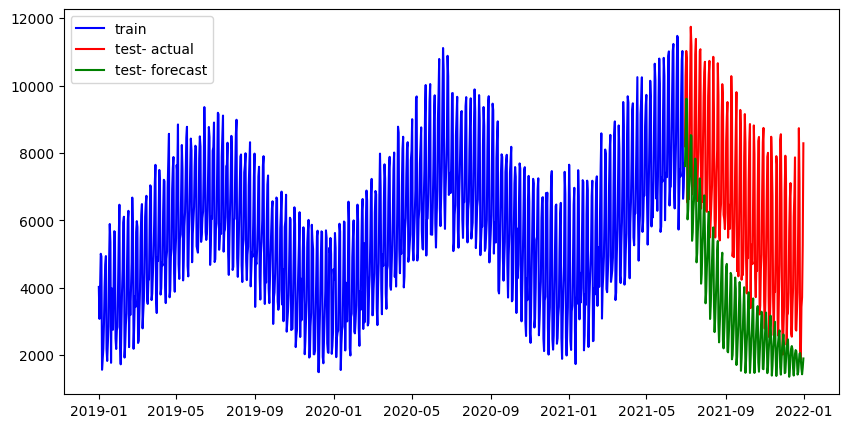

In [80]:
plt.figure(figsize = (10,5))
plt.plot(train_data, color = 'blue', label = 'train')
plt.plot(test_data.Sales, color = 'red', label = 'test- actual')
plt.plot(test_data.index, test_data.Predictions,color = 'green', label = 'test- forecast')
plt.legend()
plt.show()

In [81]:
# Calculating MAPE

mape_lstm = mean_absolute_percentage_error(test_data.Sales, test_data.Predictions)
print(f"LSTM Mean Absolute Percentage Error (MAPE): {mape_lstm:.2f}%")

LSTM Mean Absolute Percentage Error (MAPE): 0.45%


In [82]:
# Developing another model using the entire series

# Normalizing the  data

scaler = MinMaxScaler()
full_series_scaled = scaler.fit_transform(final_data_timeseries)

In [83]:
length = 3*30 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(full_series_scaled, full_series_scaled, length=length, batch_size=1)

In [84]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(generator,epochs=20)

Epoch 1/20
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 56s 53ms/step - loss: 0.0446
Epoch 2/20
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - loss: 0.0338
Epoch 3/20
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 86s 53ms/step - loss: 0.0161
Epoch 4/20
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 49s 48ms/step - loss: 0.0107
Epoch 5/20
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - loss: 0.0096
Epoch 6/20
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 80s 51ms/step - loss: 0.0088
Epoch 7/20
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - loss: 0.0068
Epoch 8/20
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 53s 52ms/step - loss: 0.0048
Epoch 9/20
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 80s 50ms/step - loss: 0.0046
Epoch 10/20
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - loss: 0.0047
Epoch 11/20
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 83s 51ms/step - loss: 0.0040
Epoch 12/20
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - loss: 0.0036
Epoch 13/20
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - loss: 0.0038
Epoch 14/20
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - loss: 0.0038
E

<Axes: >

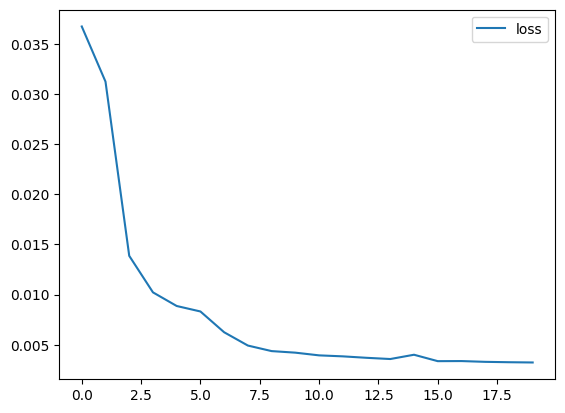

In [85]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [86]:
# Evaluate the predictions on batches. Forecasting for the next three months

forecast = []
periods =3*30

first_eval_batch = full_series_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    # store prediction
    forecast.append(current_pred)
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

In [87]:
forecast = scaler.inverse_transform(forecast)

In [88]:
forecast_dates = pd.date_range(start='2022-01-01 ',periods=3*30, freq = "D")

In [89]:
forecast_data = pd.DataFrame(data=forecast,index=forecast_dates,
                           columns=['Forecast']).squeeze()

In [90]:
forecast_data

2022-01-01    7014.266768
2022-01-02    2215.250862
2022-01-03    2796.607634
2022-01-04    3361.112866
2022-01-05    3898.625288
                 ...     
2022-03-27    1942.839230
2022-03-28    2279.855931
2022-03-29    2816.164383
2022-03-30    3369.969640
2022-03-31    4918.512877
Freq: D, Name: Forecast, Length: 90, dtype: float64

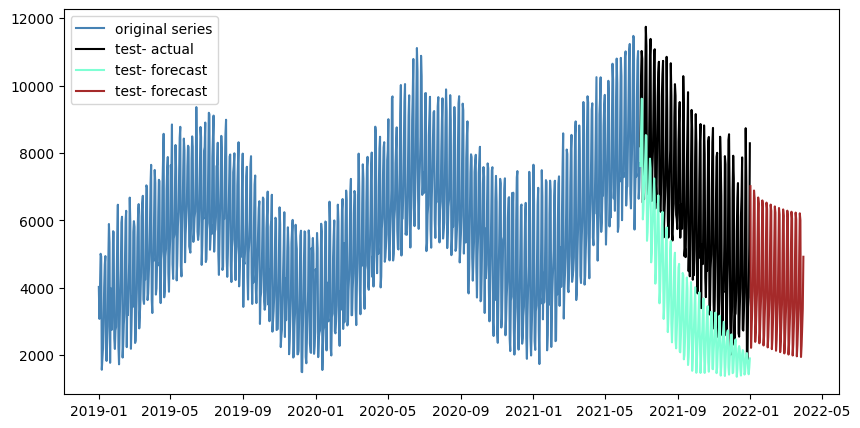

In [91]:
plt.figure(figsize = (10,5))
plt.plot(train_data.index, train_data.Sales, color = 'steelblue', label = 'original series')
plt.plot(test_data.index, test_data.Sales,color = 'black', label = 'test- actual')
plt.plot(test_data.index, test_data.Predictions,color = 'aquamarine', label = 'test- forecast')
plt.plot(forecast_data.index, forecast_data.values, color = 'brown', label = 'test- forecast')
plt.legend()
plt.show()